In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [67]:
df = pd.read_parquet("../../data/join/all.parquet")
icaos = []
for (icao, id, day, month), flight in df.groupby(["icao", "flight_id", "day", "month"], observed=True):
    if len(flight["holding_point_id"].unique()) != 1:
        icaos.append(icao)
df = df[~df["icao"].isin(icaos)]

icaos = []
tol_m = 50.0
tol_deg_lon = tol_m / (111_111 * np.cos(np.deg2rad(df["lat_espera"])))
mask = ((df["lat"] - df["lat_espera"]).abs() > tol_m / 111_111  ) | ((df["lon"] - df["lon_espera"]).abs() > tol_deg_lon)
icaos = df[mask]["icao"].unique()
df = df[~df["icao"].isin(icaos)]

max_hold = df['num_holding_aircrafts'].max()
max_pista = df['num_en_pista_aircrafts'].max()
max_yendo = df['num_yendo_a_pista_aircrafts'].max()
for i in range(max_hold):
    df[f'distancias_holdings_{i}'] = df['distancias_holdings'].apply(lambda x: x[i] if x is not None and len(x) > i else None)
    df[f'tiempo_holding_{i}'] = df['tiempo_holding'].apply(lambda x: x[i] if x is not None and len(x) > i else None)
for i in range(max_pista):
    df[f'distancia_en_pista_{i}'] = df['distancia_en_pista'].apply(lambda x: x[i] if x is not None and len(x) > i else None)
for i in range(max_yendo):
    df[f'distancia_yendo_a_pista_{i}'] = df['distancia_yendo_a_pista'].apply(lambda x: x[i] if x is not None and len(x) > i else None)
df = df.drop(columns=['distancias_holdings', 'tiempo_holding', 'distancia_en_pista', 'distancia_yendo_a_pista'])

In [68]:
colsToShow = df.columns.drop(["msg_hex", "hora_despegue", "icao_ultimo_despegue", "llegada_punto_espera", "icaos_holdings", "despegue_holdings", "icaos_en_pista", "icaos_yendo_a_pista"])
df1 = df[colsToShow]

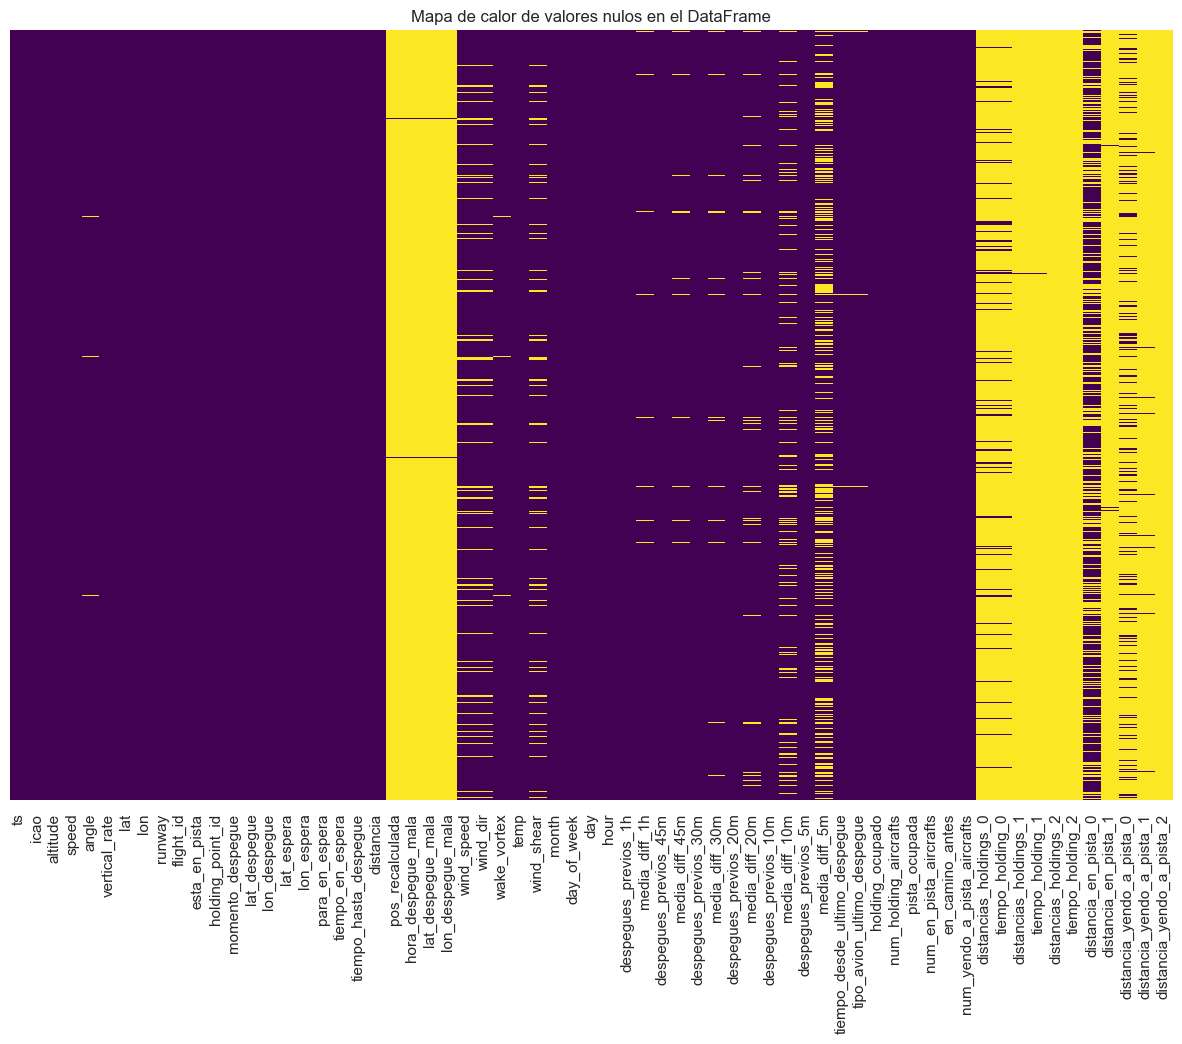

In [69]:
plt.figure(figsize=(15, 10))
sns.heatmap(df1.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Mapa de calor de valores nulos en el DataFrame")
plt.show()

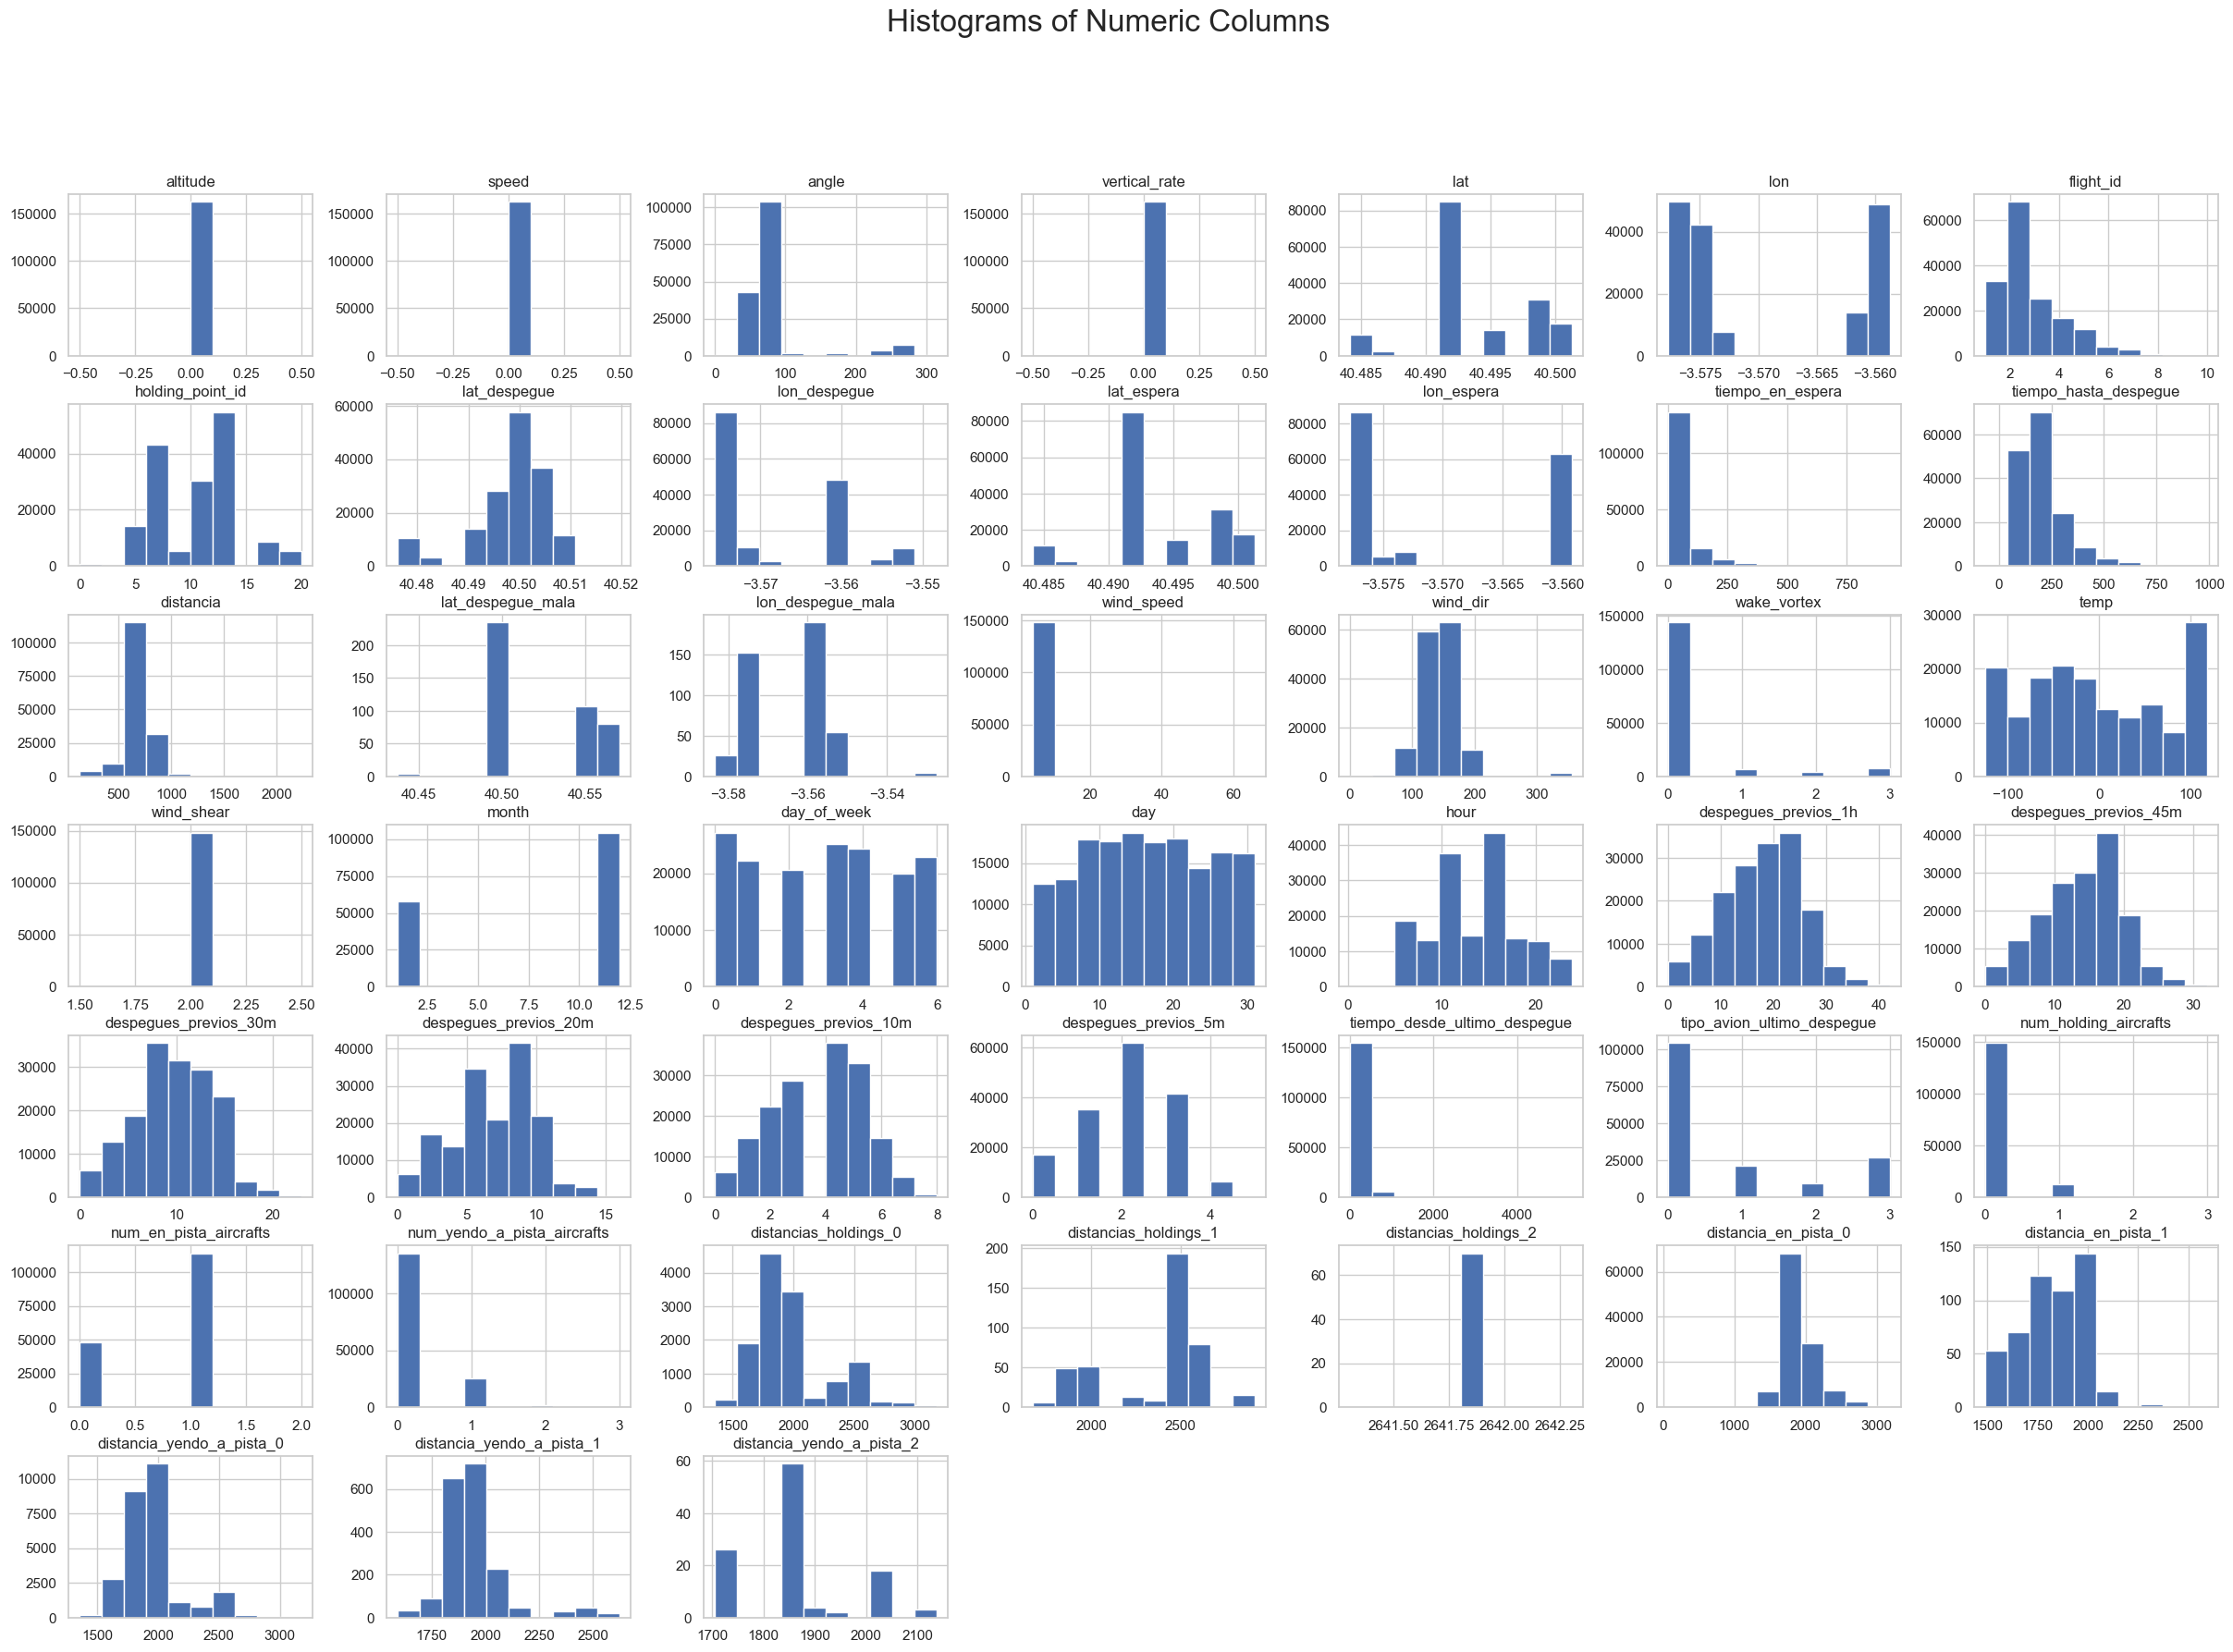

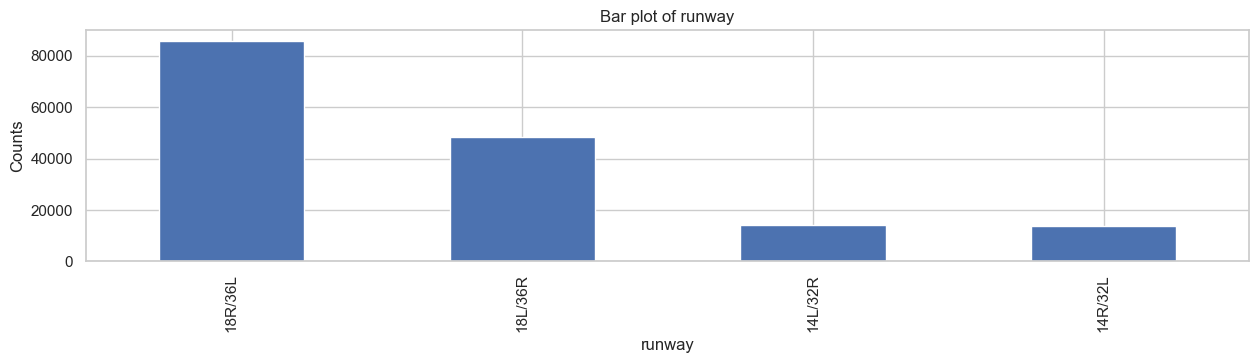

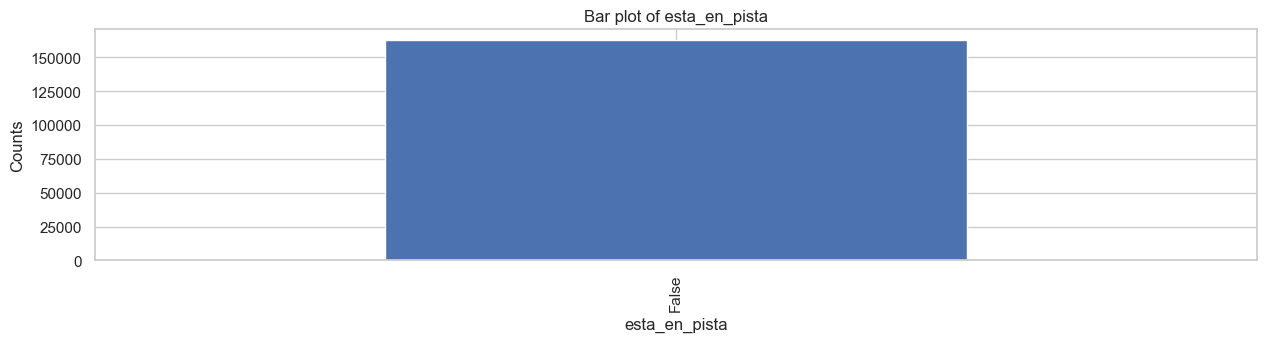

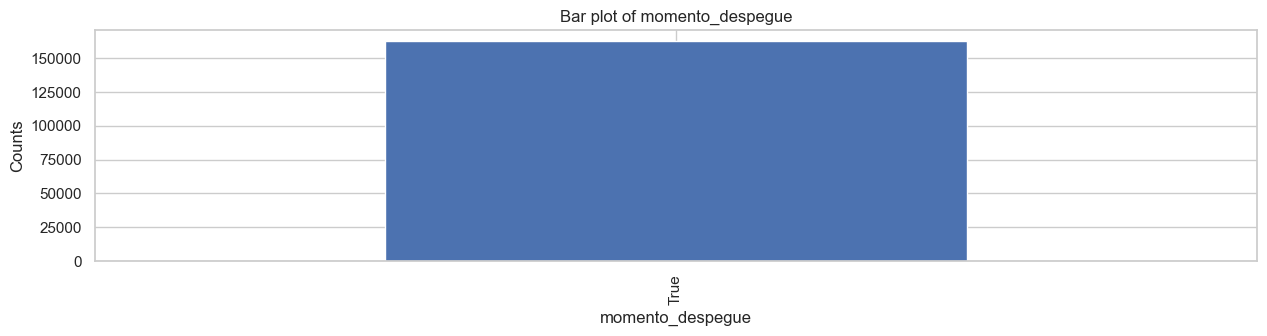

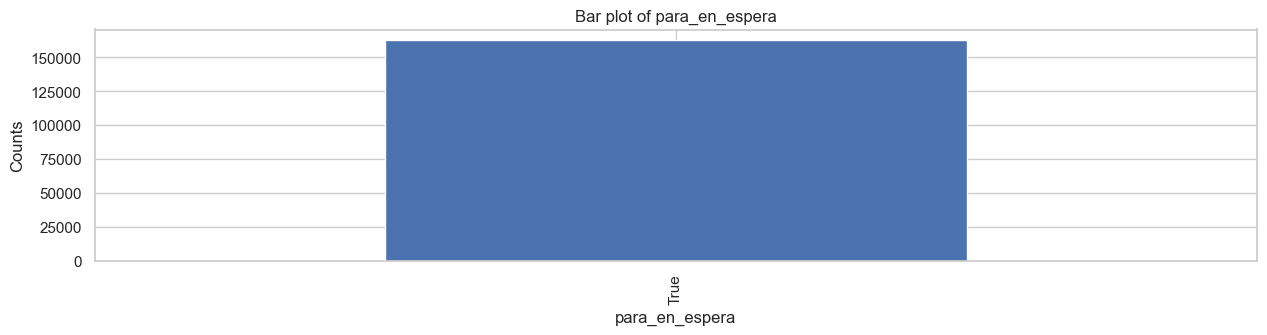

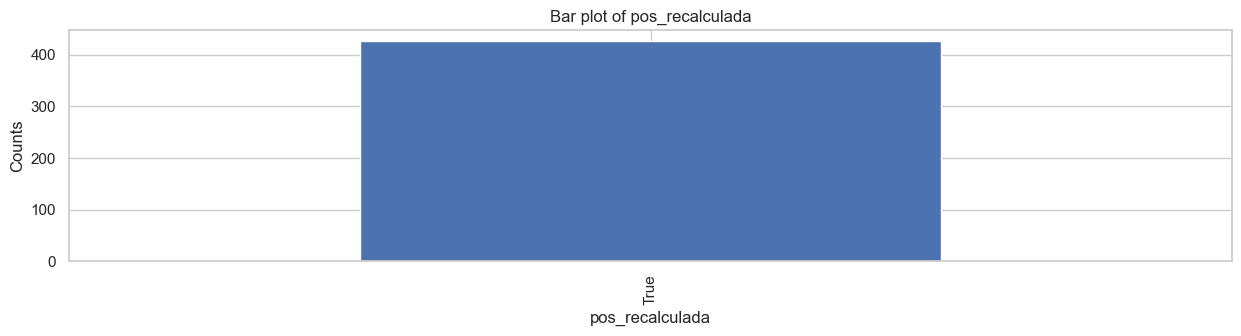

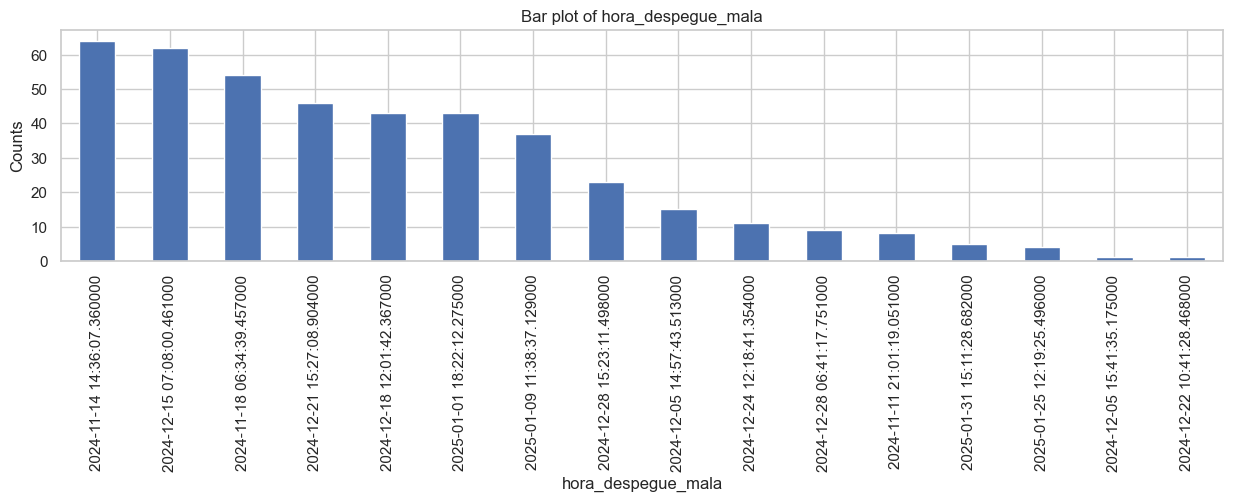

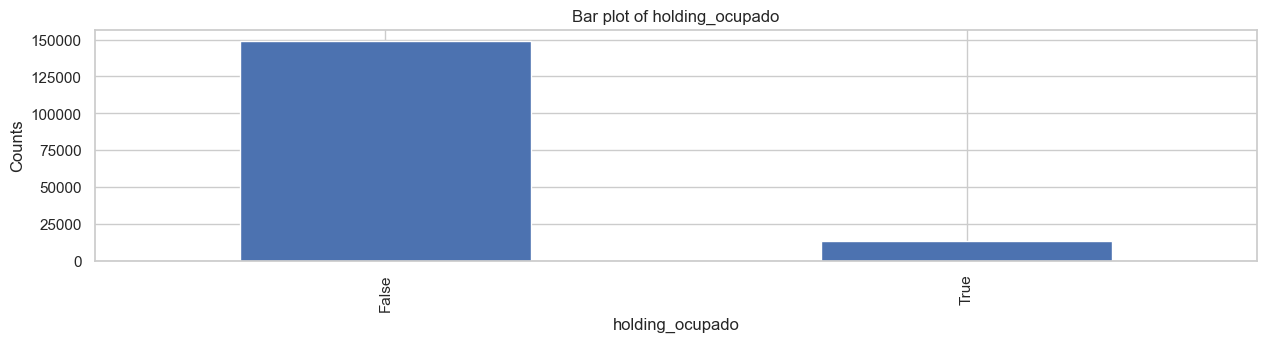

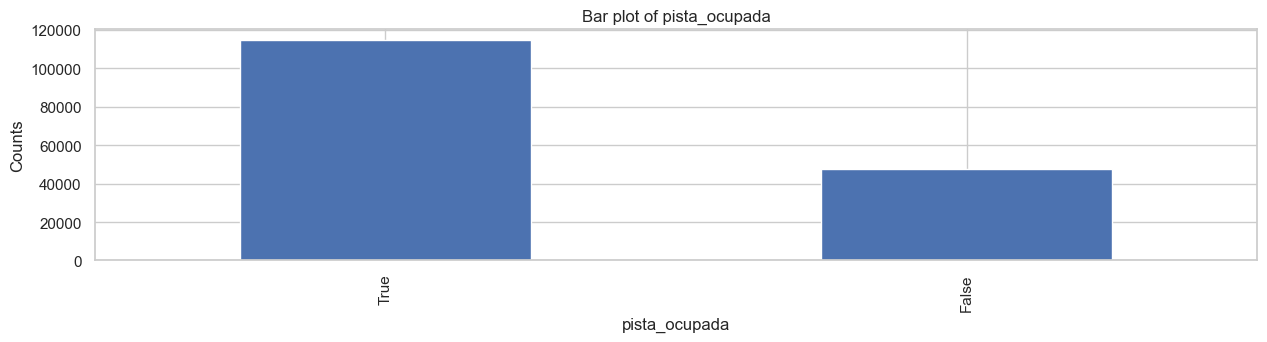

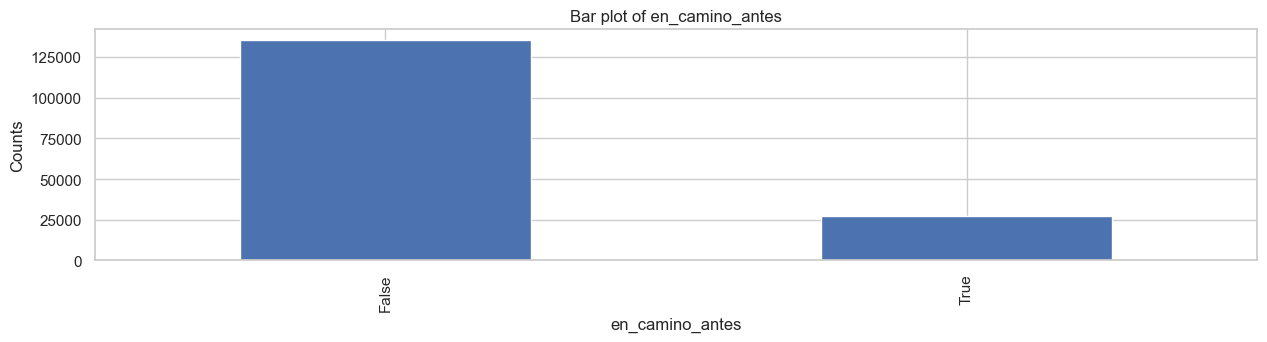

In [70]:
import matplotlib.pyplot as plt
import numpy as np
numeric_cols = df1.select_dtypes(include=[np.number]).columns
categorical_cols = df1.select_dtypes(exclude=[np.number]).columns.drop(["ts", "icao"])
axes = df1[numeric_cols].hist(figsize=(30, 20))
plt.suptitle('Histograms of Numeric Columns', fontsize=24)
#for ax in axes.flatten():
 #   ax.set_yscale('log')
plt.show()
for col in categorical_cols:
    if df1[col].isna().sum() < len(df1):
        counts = df1[col].value_counts().head(20)
        counts.plot(kind='bar', figsize=(15, 3), title=f'Bar plot of {col}')
        plt.xlabel(col)
        plt.ylabel('Counts')
        plt.show()
    else:
        print(col)

In [71]:
colsDrop = ["altitude", "speed", "angle", "vertical_rate", "lat", "lon", "lat_espera", "lon_espera", "lat_despegue", "lon_despegue", "lat_espera", "lon_espera", "lat_despegue_mala", "lon_despegue_mala", "esta_en_pista", "momento_despegue", "para_en_espera", "pos_recalculada", "hora_despegue_mala"]
df2 = df1.drop(colsDrop, axis=1)

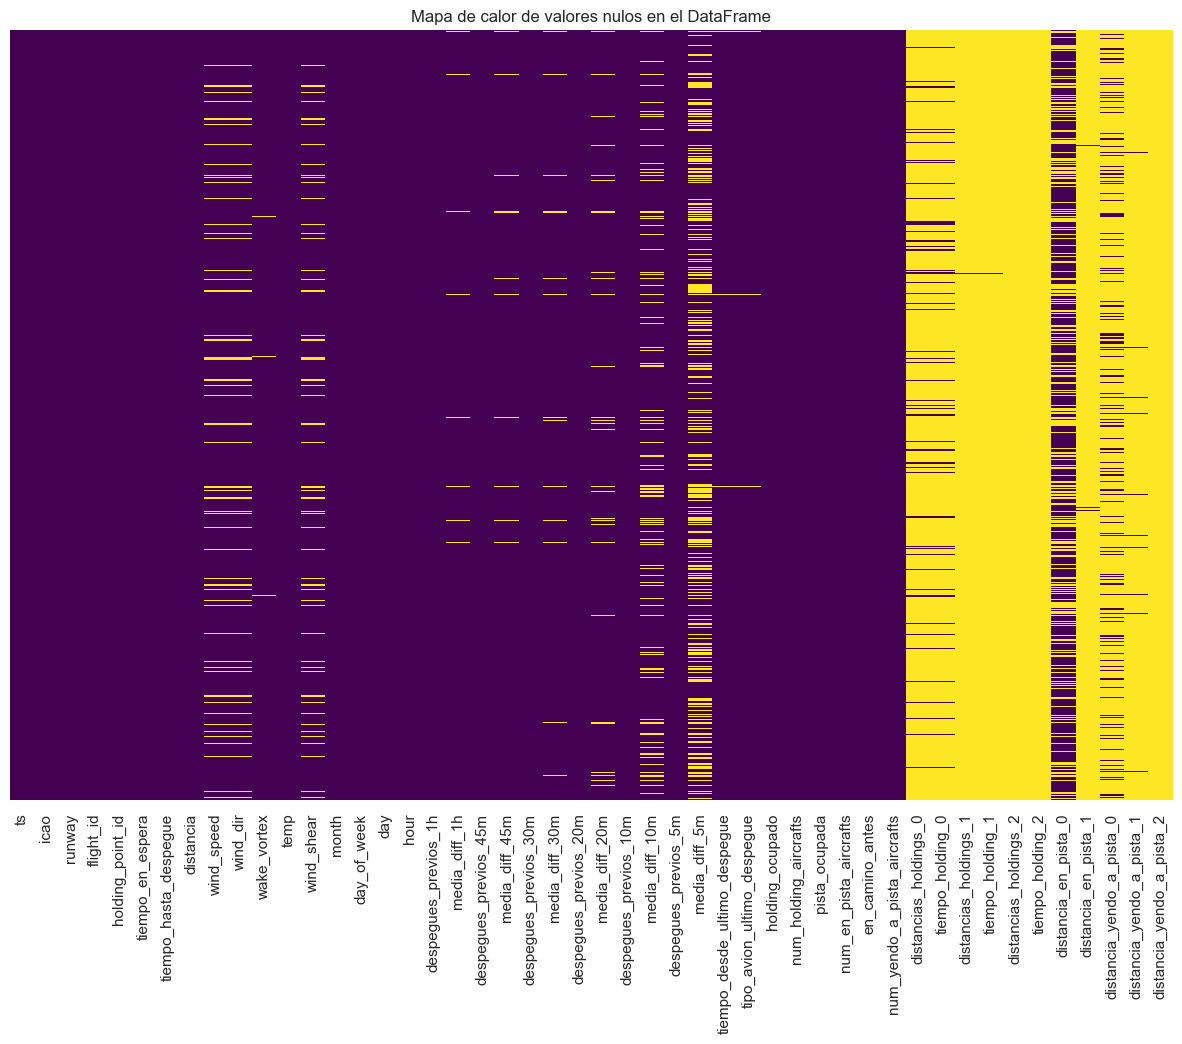

In [72]:
plt.figure(figsize=(15, 10))
sns.heatmap(df2.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Mapa de calor de valores nulos en el DataFrame")
plt.show()

In [73]:
df["despegues_previos_30m"].isna().sum()

0

In [74]:
df3 = df2.copy()
for col in ['media_diff_1h', 'media_diff_45m', 'media_diff_30m', 'media_diff_20m', 'media_diff_10m', 'media_diff_5m', 'tiempo_holding_0', 'tiempo_holding_1', 'tiempo_holding_2']:
    df3[col] = df3[col].fillna(pd.Timedelta(seconds=-1)).dt.total_seconds()
for col in ['distancias_holdings_0', 'distancias_holdings_1', 'distancias_holdings_2', 'distancia_en_pista_0', 'distancia_en_pista_1', 'distancia_yendo_a_pista_0', 'distancia_yendo_a_pista_1', 'distancia_yendo_a_pista_2']:
    df3[col] = df3[col].fillna(-1)
df3["tiempo_desde_ultimo_despegue"] = df3["tiempo_desde_ultimo_despegue"].fillna(-1)
df3["tipo_avion_ultimo_despegue"] = df3["tipo_avion_ultimo_despegue"].fillna(-1)

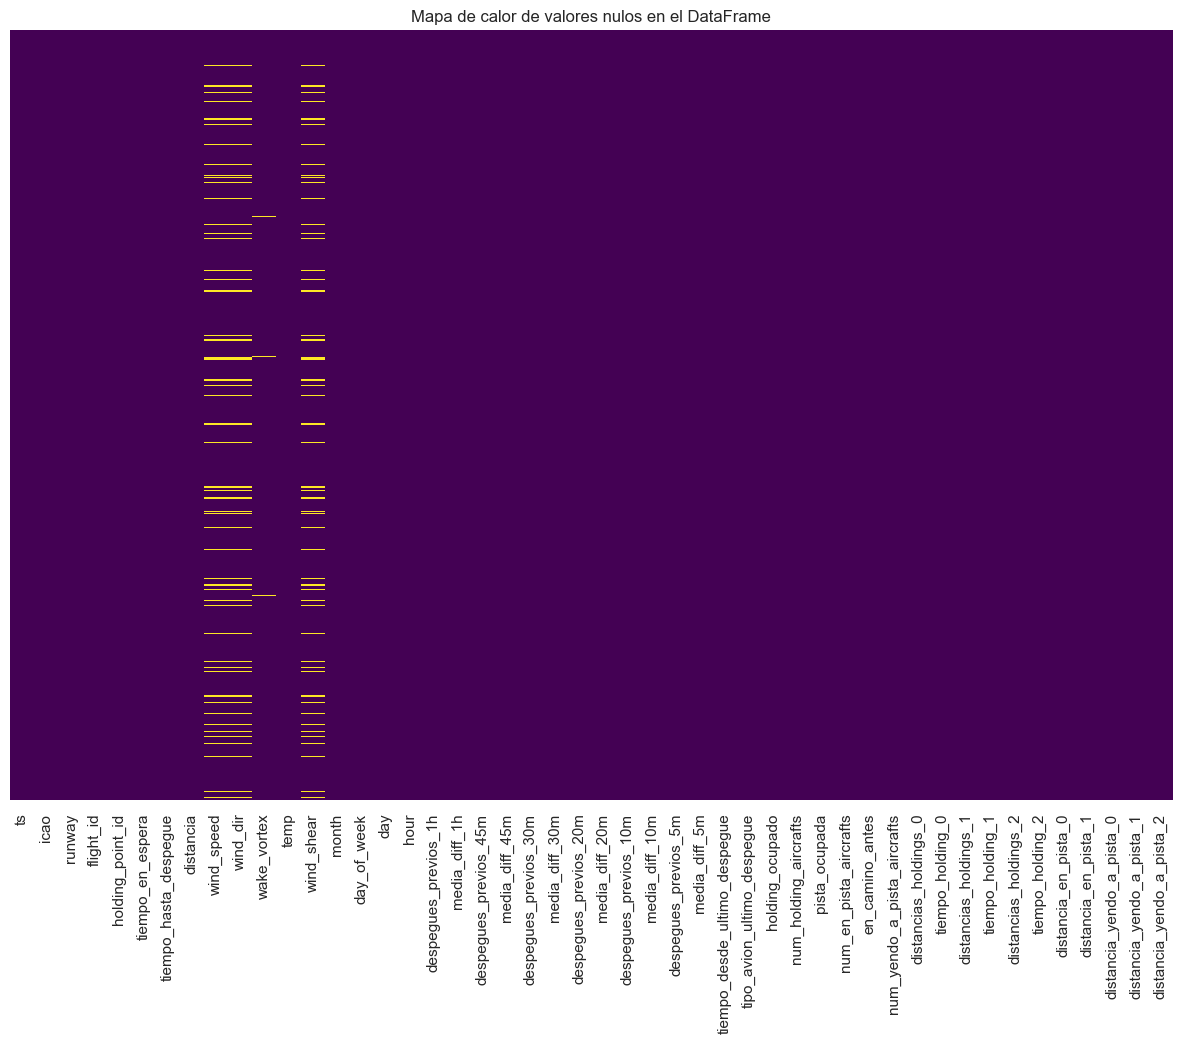

In [75]:
plt.figure(figsize=(15, 10))
sns.heatmap(df3.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Mapa de calor de valores nulos en el DataFrame")
plt.show()

In [76]:
df4 = df3.drop(["icao", "ts"], axis=1)

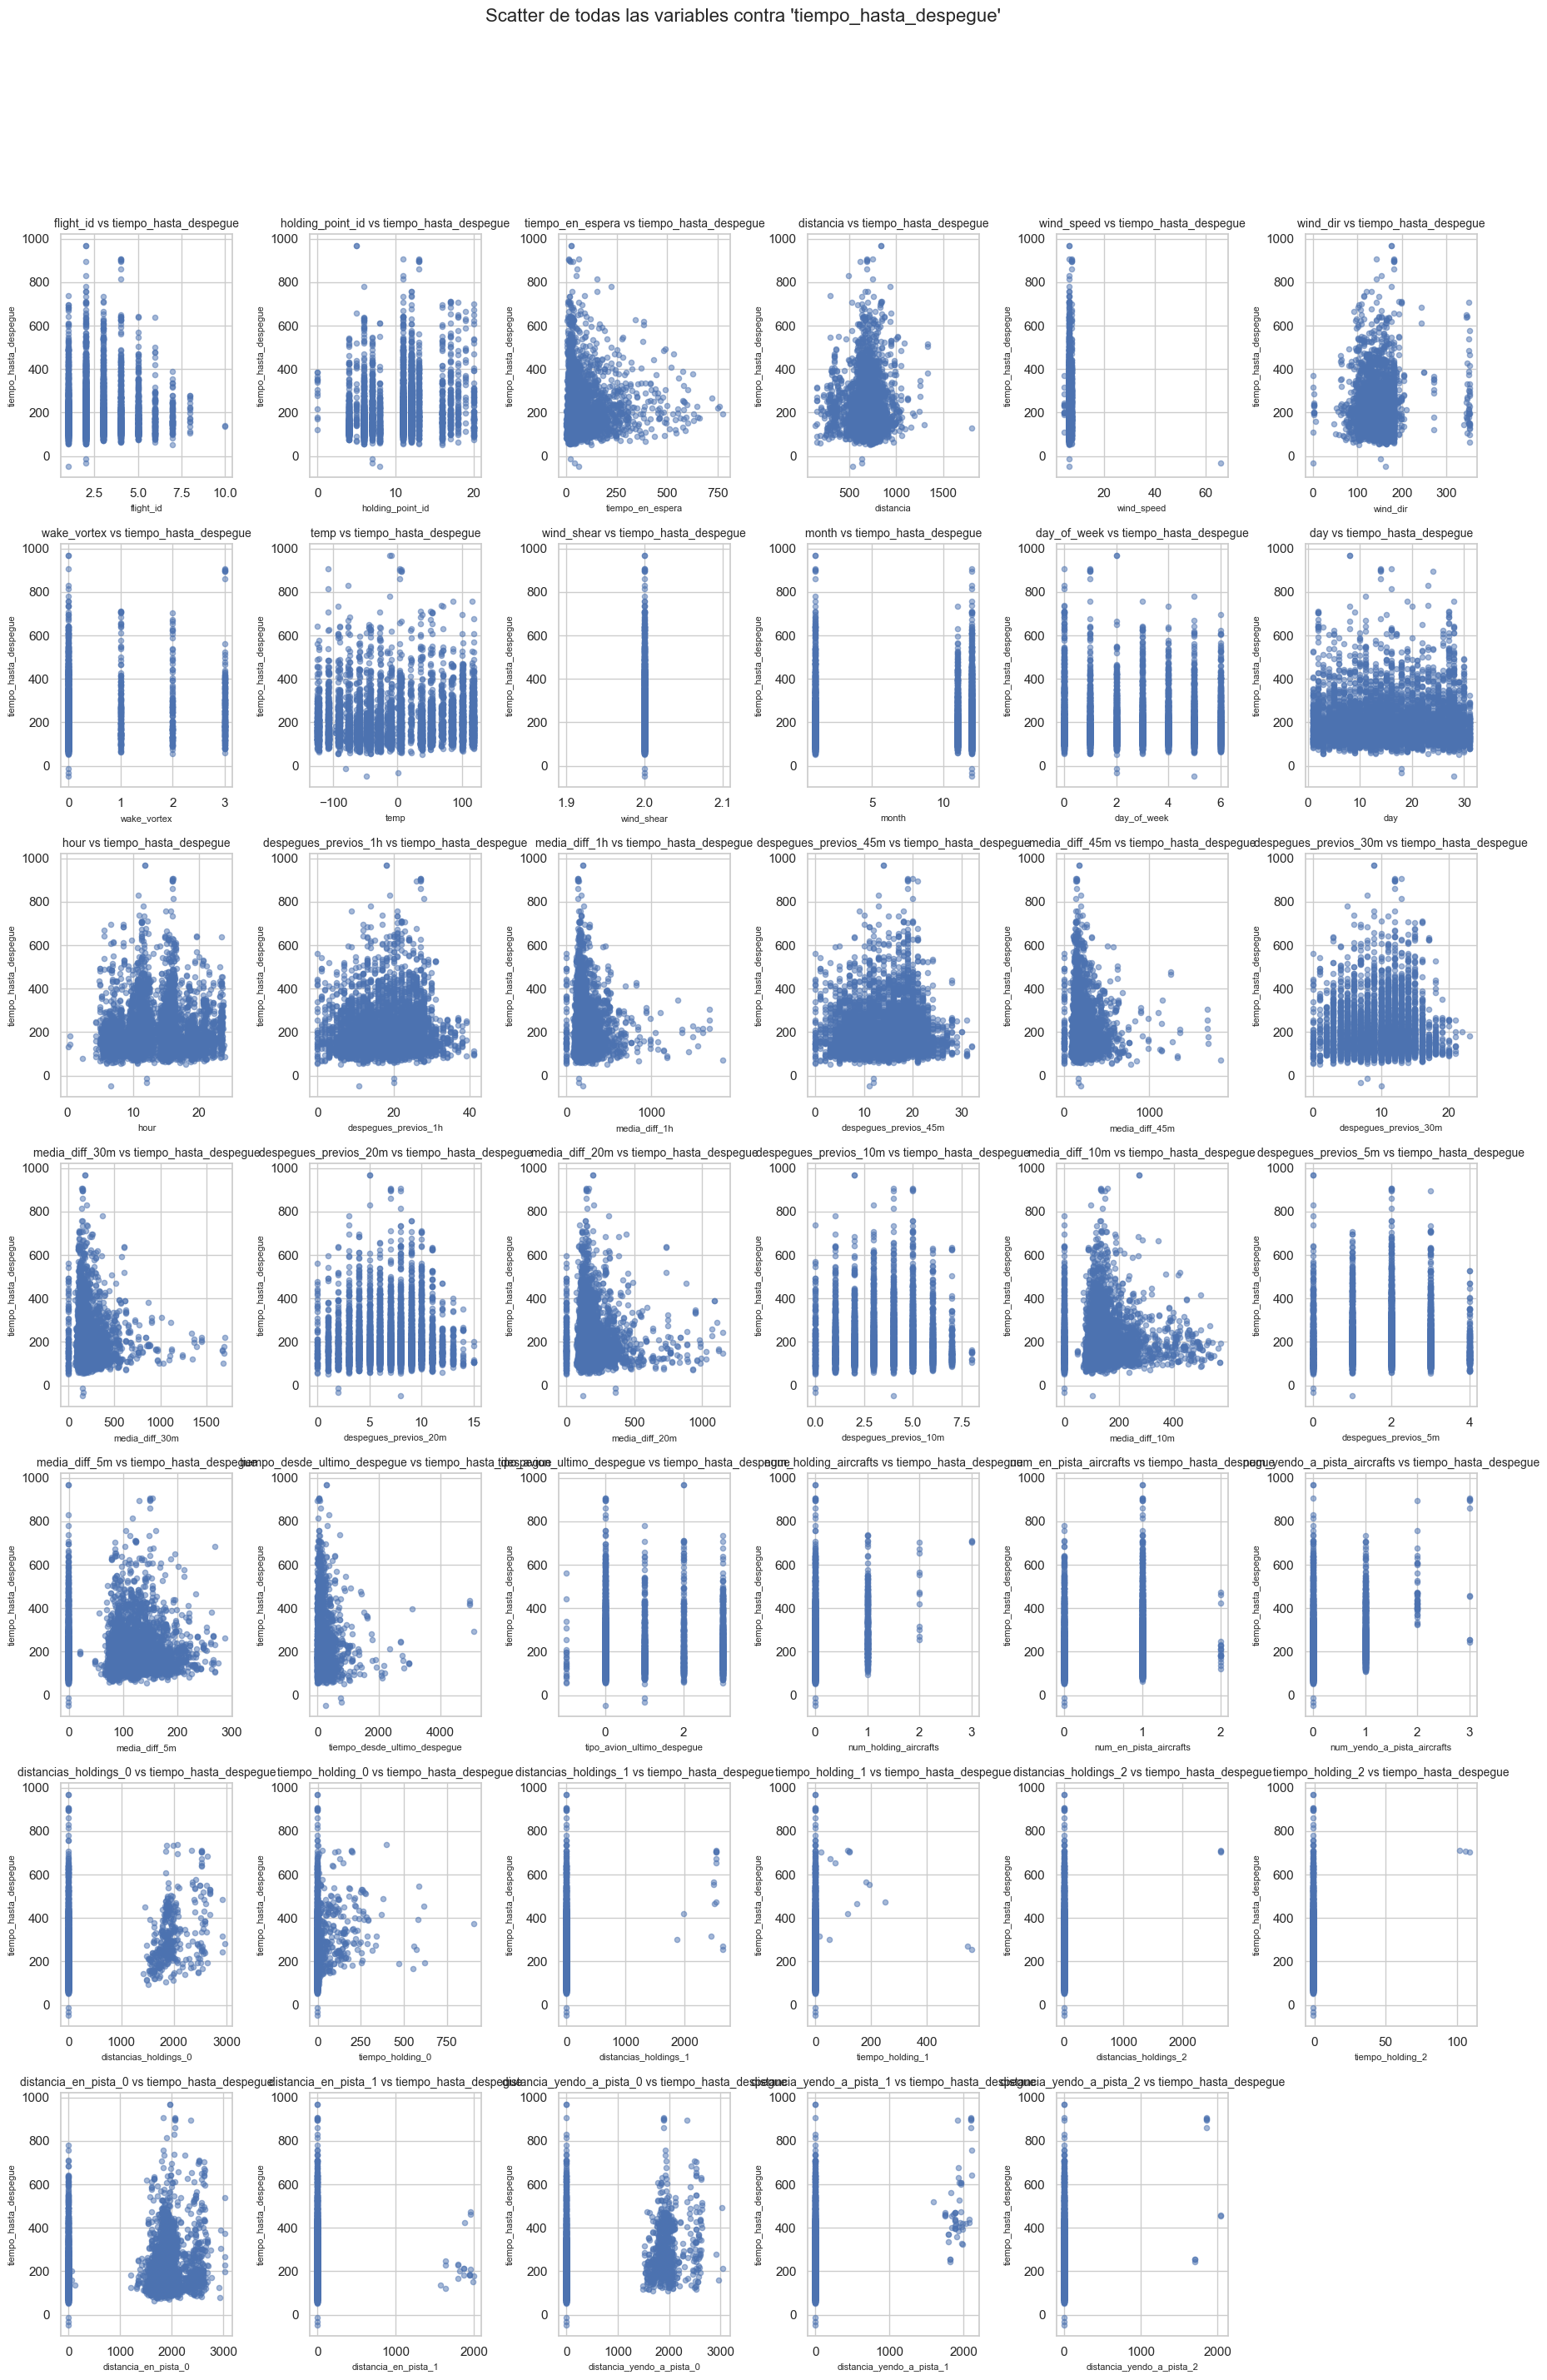

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import math

# --- 1) Definir variables ---
target_cols = ["tiempo_hasta_despegue"]

# Columnas numéricas sin duplicados
numeric = df4.select_dtypes(include=[np.number])
feature_cols = [c for c in numeric.columns.drop_duplicates() 
                if c not in target_cols]

# Para rendimiento, muestreamos si hay muchas filas
df_plot = df4.sample(5000, random_state=42) if len(df1) > 10000 else df1

# --- 2) Loop por cada target ---
for target in target_cols:
    n_feats = len(feature_cols)
    if n_feats == 0:
        print(f"No hay features numéricos para graficar contra {target}")
        continue
    ncols = 6
    nrows = math.ceil(n_feats / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(18, nrows*4))
    axes = axes.flatten()
    
    for i, feat in enumerate(feature_cols):
        try:
            ax = axes[i]
            ax.scatter(df_plot[feat], df_plot[target], alpha=0.5, s=20)
            ax.set_xlabel(feat, fontsize=8)
            ax.set_ylabel(target, fontsize=8)
            ax.set_title(f"{feat} vs {target}", fontsize=10)
        except:
            print(feat)

    # Ocultar ejes sobrantes
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    
    plt.suptitle(f"Scatter de todas las variables contra '{target}'", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

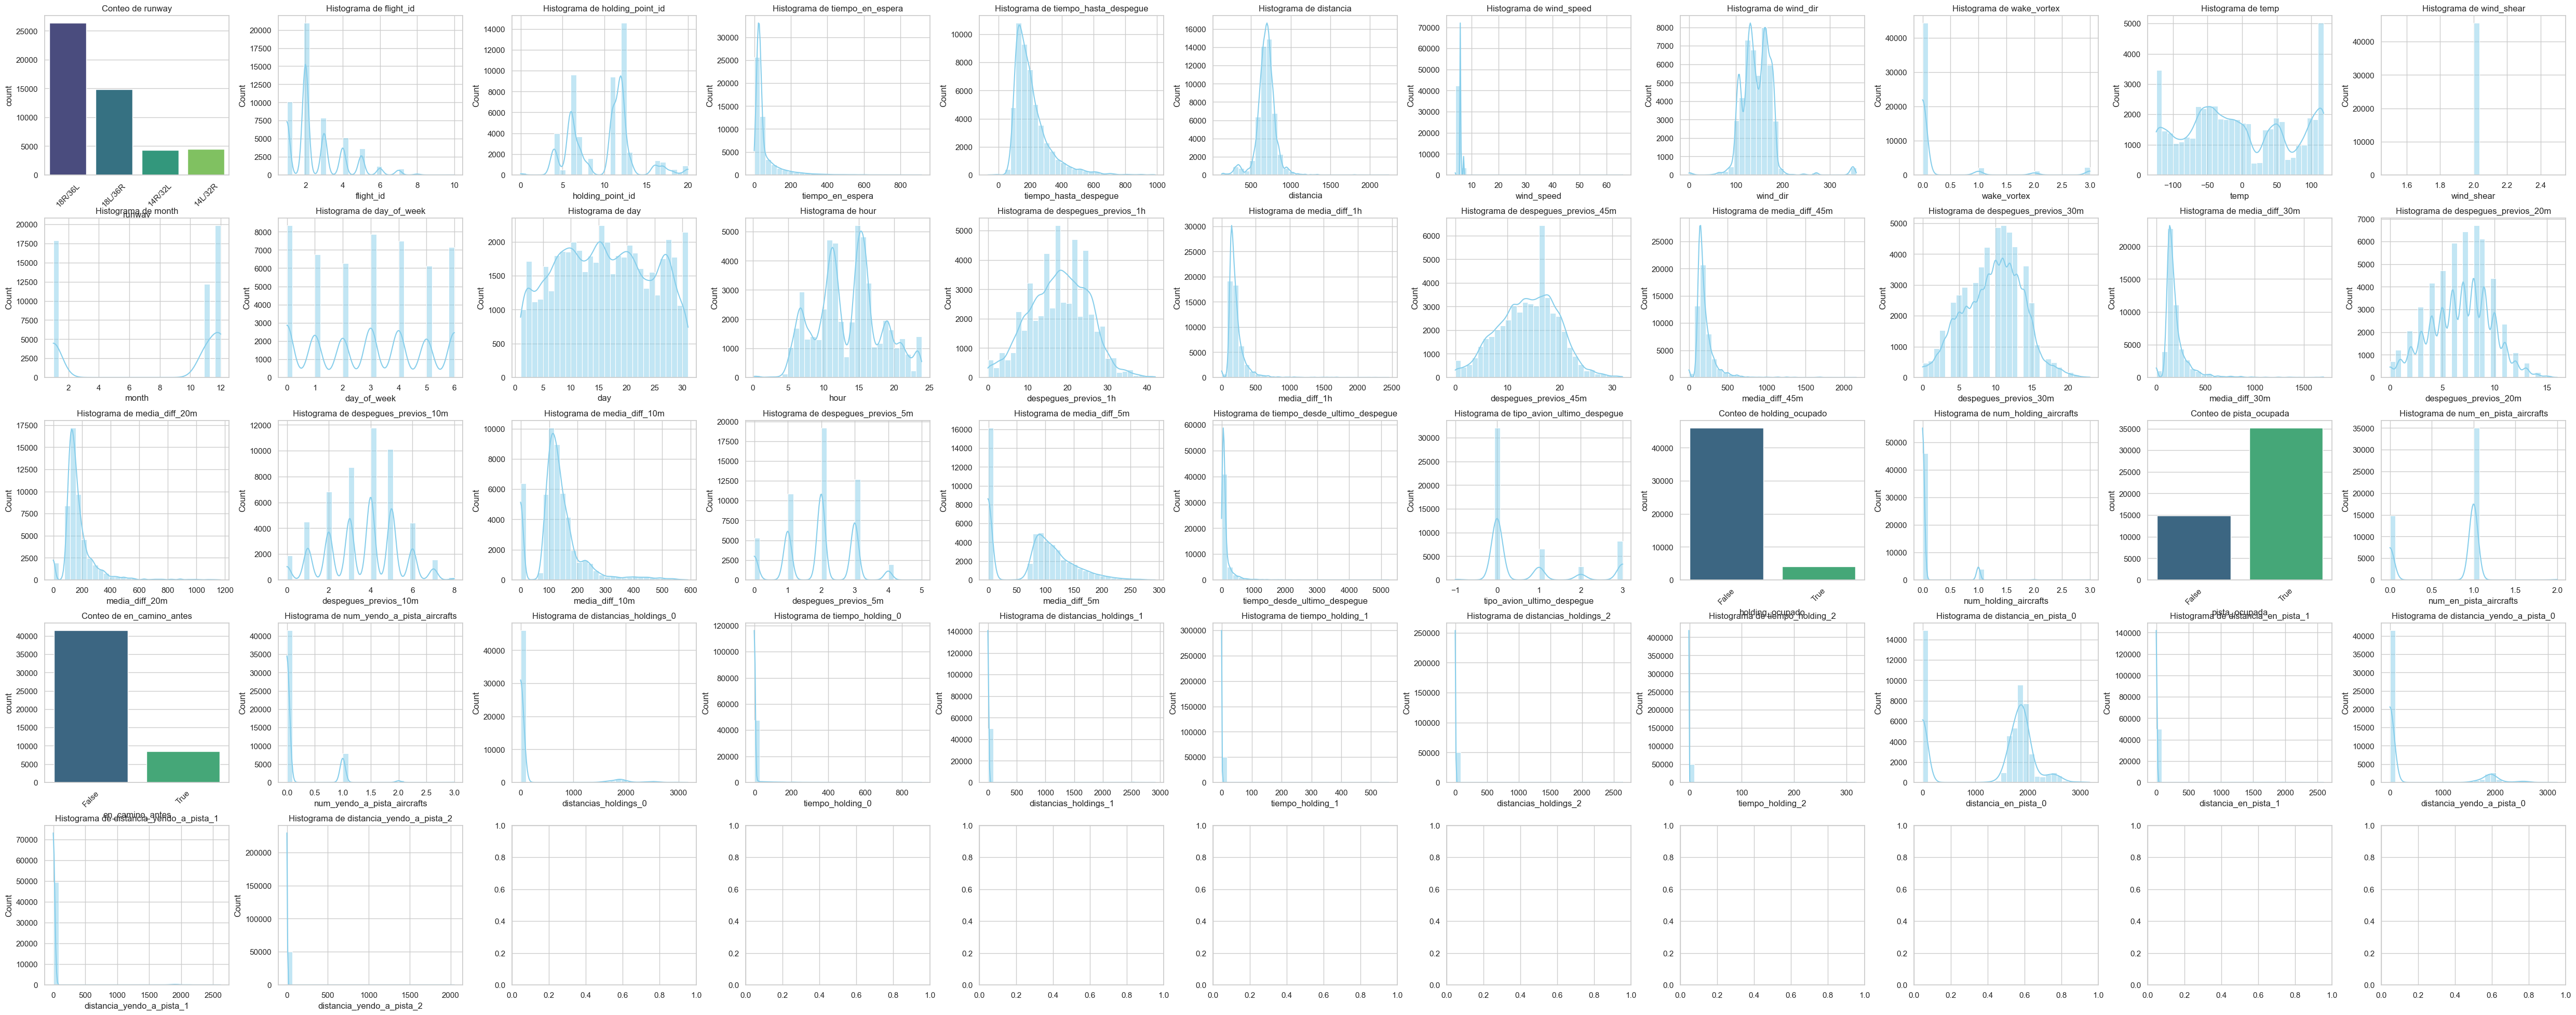

In [78]:
sns.set(style="whitegrid")
df_sample = df4.sample(n=50000, random_state=42)
numeric_cols = df_sample.select_dtypes(include=[np.number]).columns
categorical_cols = df_sample.select_dtypes(exclude=[np.number]).columns
n_cols = 11
n_rows = int(np.ceil(len(df_sample.columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(50, n_rows * 4))
fig.tight_layout(pad=3.0)
for i, col in enumerate(df_sample.columns):
    row = i // n_cols
    col_pos = i % n_cols
    if n_rows == 1:
        ax = axes[col_pos]
    else:
        ax = axes[row, col_pos]
    if col in numeric_cols:
        try:
            sns.histplot(df_sample[col], kde=True, ax=ax, color='skyblue', bins=30)
            ax.set_title(f'Histograma de {col}')
        except:
            print(col)
    elif col in categorical_cols:
        try:
            sns.countplot(data=df_sample, x=col, ax=ax, palette='viridis')
            ax.set_title(f'Conteo de {col}')
            ax.tick_params(axis='x', rotation=45)
        except: 
            print(col)
    else:
        ax.axis('off')
plt.show()

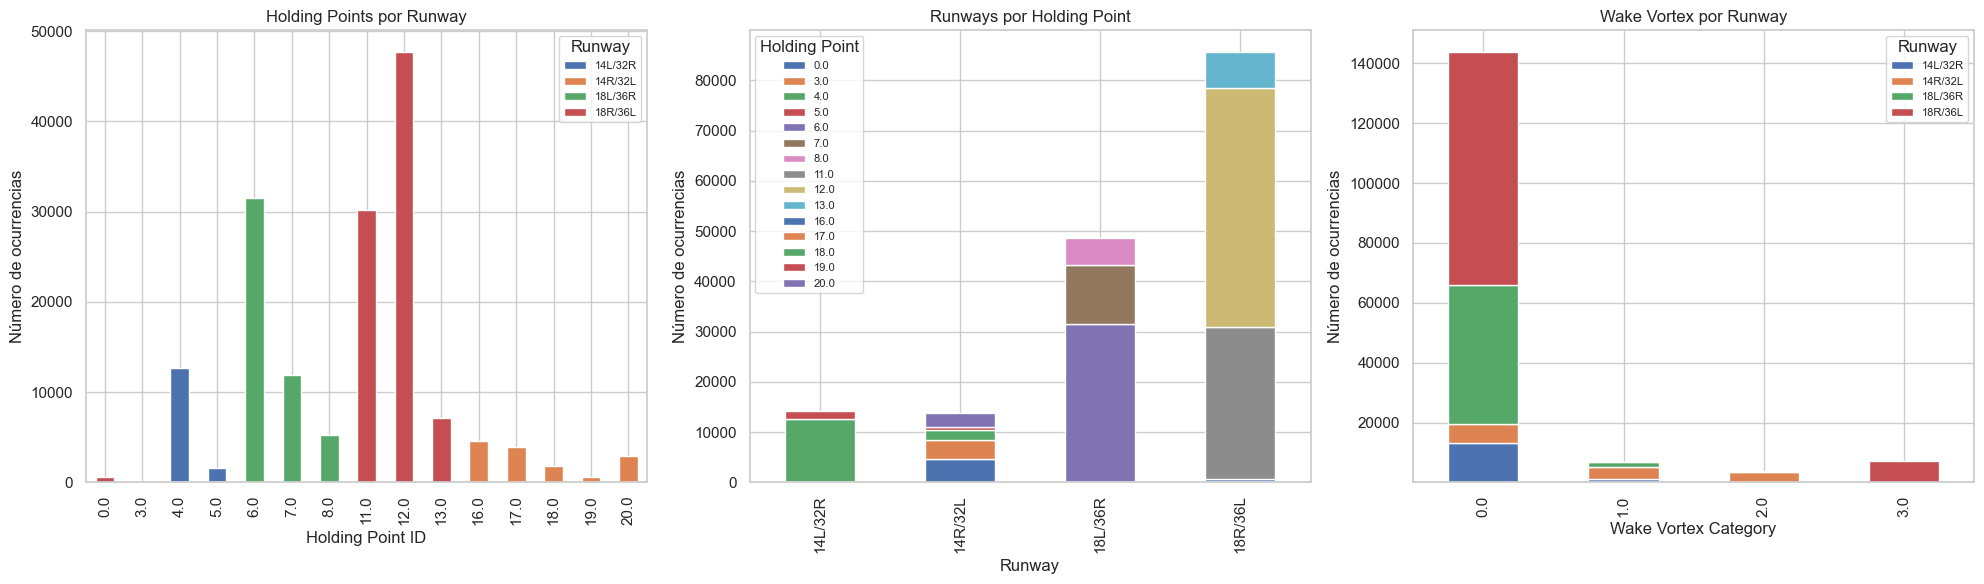

In [79]:
cols = ['runway', 'holding_point_id', 'wake_vortex',]
aux = df4[cols]
import pandas as pd
import matplotlib.pyplot as plt

# Suponiendo que tu DataFrame se llama 'df' y tiene las columnas:
# 'holding_point_id', 'runway', 'wake_vortex'

# Crear la figura con 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # 1 fila, 3 columnas

# 1. Primer gráfico: holding_point_id, apilado por runway
tabla1 = pd.crosstab(aux["holding_point_id"], aux["runway"])
tabla1.plot(kind="bar", stacked=True, ax=axes[0])

axes[0].set_title("Holding Points por Runway")
axes[0].set_xlabel("Holding Point ID")
axes[0].set_ylabel("Número de ocurrencias")
axes[0].legend(title="Runway", fontsize=8)

# 2. Segundo gráfico: runway, apilado por holding_point_id
tabla2 = pd.crosstab(aux["runway"], aux["holding_point_id"])
tabla2.plot(kind="bar", stacked=True, ax=axes[1])

axes[1].set_title("Runways por Holding Point")
axes[1].set_xlabel("Runway")
axes[1].set_ylabel("Número de ocurrencias")
axes[1].legend(title="Holding Point", fontsize=8)

# 3. Tercer gráfico: wake_vortex, apilado por runway
tabla3 = pd.crosstab(aux["wake_vortex"], aux["runway"])
tabla3.plot(kind="bar", stacked=True, ax=axes[2])

axes[2].set_title("Wake Vortex por Runway")
axes[2].set_xlabel("Wake Vortex Category")
axes[2].set_ylabel("Número de ocurrencias")
axes[2].legend(title="Runway", fontsize=8)

# Ajustar diseño
plt.tight_layout()
plt.show()


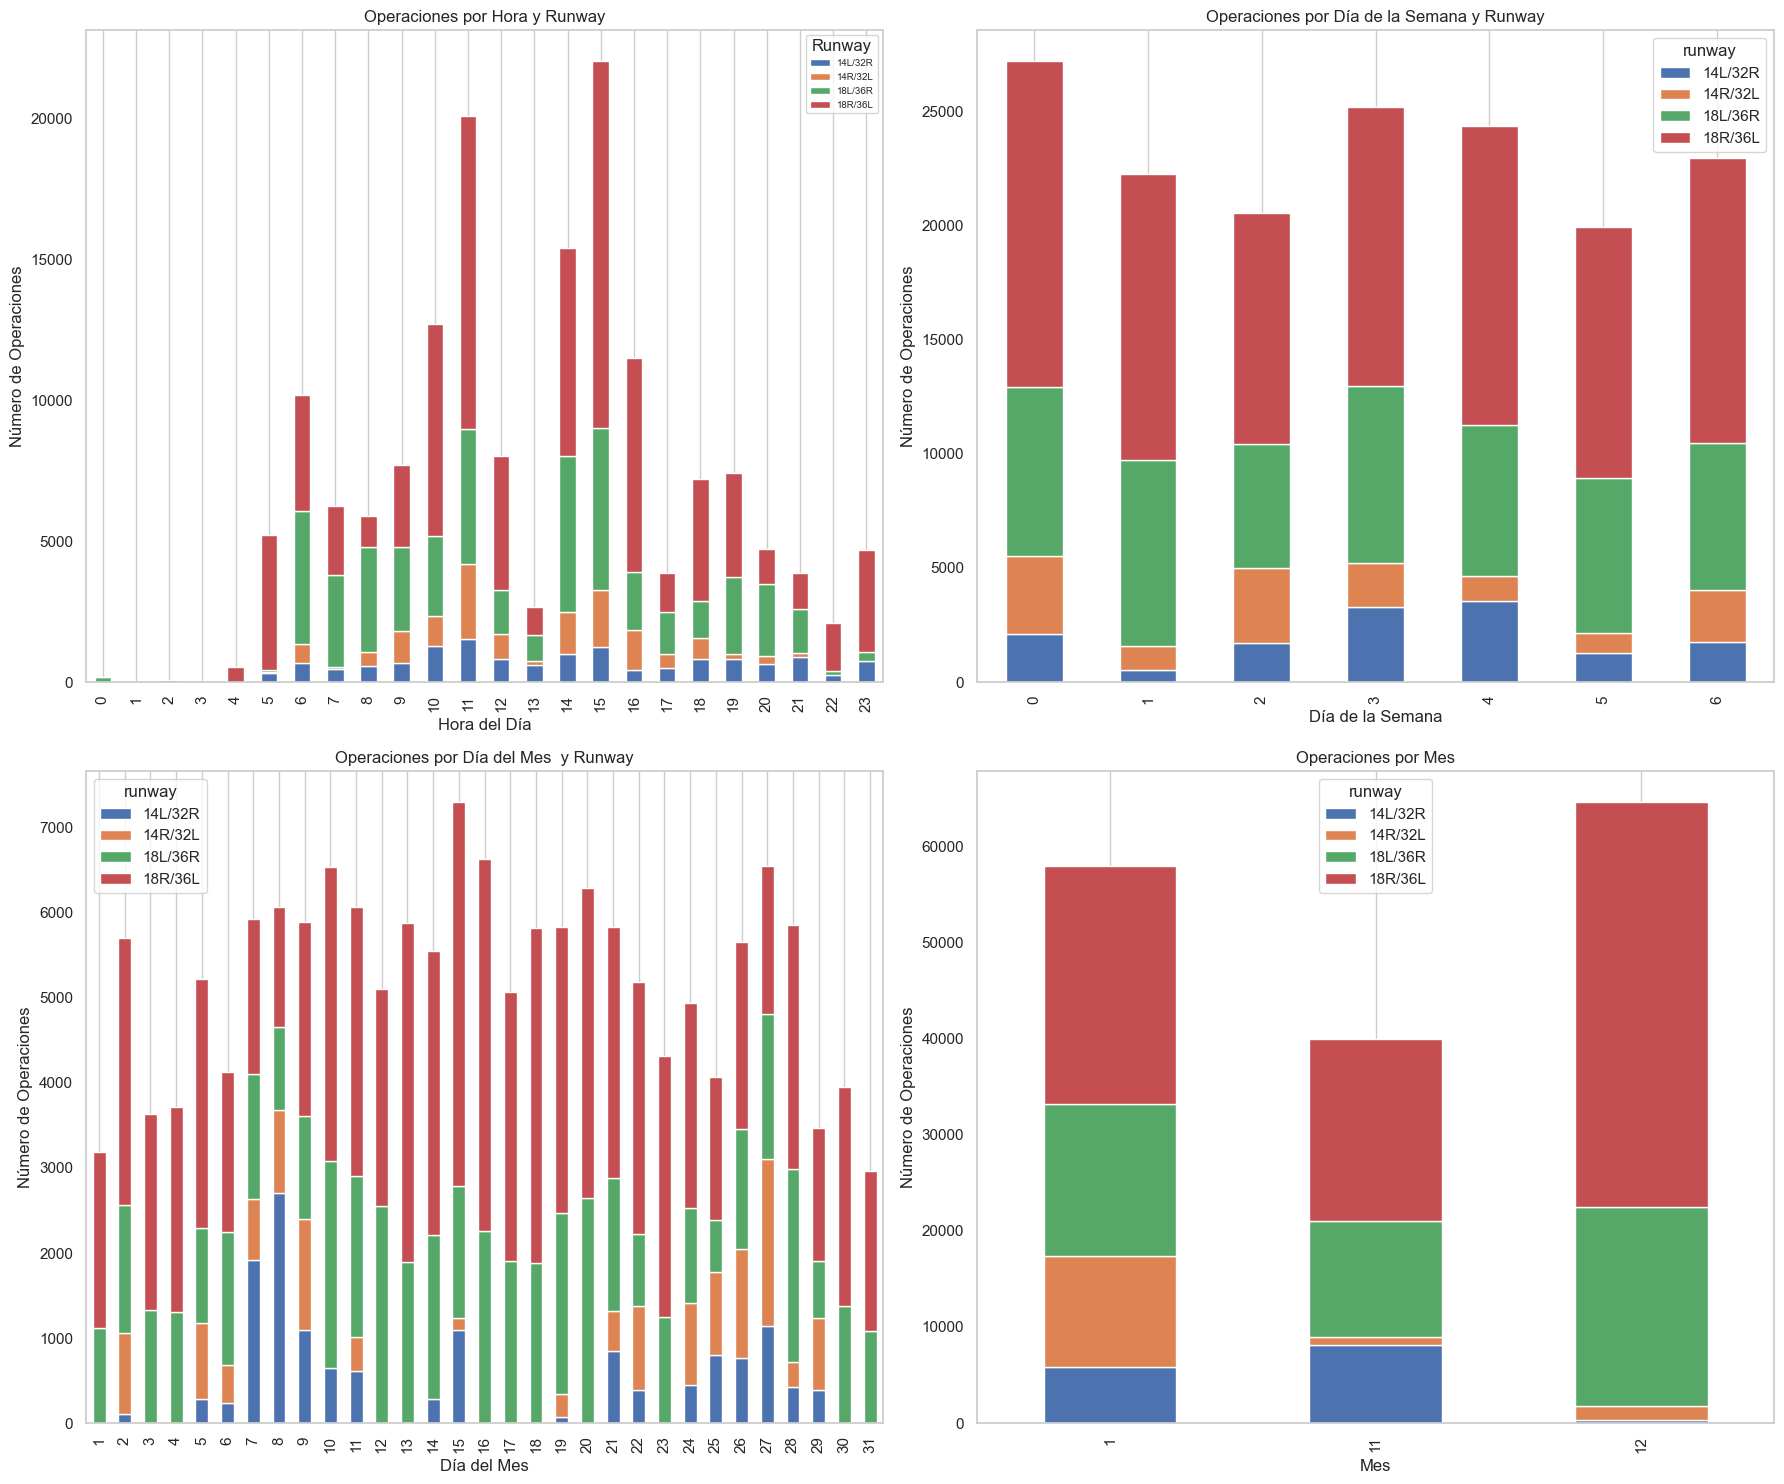

In [80]:
cols = ['month', 'day_of_week', 'day', 'hour', "wake_vortex", "runway"]
aux = df4[cols]

# Crear nombres de días de la semana
dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
aux["day_of_week_name"] = aux["day_of_week"].map(dict(enumerate(dias)))

# Crear figura y ejes
fig, axes = plt.subplots(2, 2, figsize=(18, 15))  # 3 filas x 2 columnas

# 2. Operaciones por hora y runway
tabla_hour_runway = pd.crosstab(aux["hour"].astype(int), aux["runway"])
tabla_hour_runway.plot(kind="bar", stacked=True, ax=axes[0,0])

axes[0,0].set_title("Operaciones por Hora y Runway")
axes[0,0].set_xlabel("Hora del Día")
axes[0,0].set_ylabel("Número de Operaciones")
axes[0,0].legend(title="Runway", fontsize=7)
axes[0,0].set_xticks(range(0,24))
axes[0,0].grid(axis="y")

# 3. Operaciones por día de la semana
tabla_day_week_runway = pd.crosstab(aux["day_of_week"], aux["runway"])
tabla_day_week_runway.plot(kind="bar", stacked=True, ax=axes[0,1])

axes[0,1].set_title("Operaciones por Día de la Semana y Runway")
axes[0,1].set_xlabel("Día de la Semana")
axes[0,1].set_ylabel("Número de Operaciones")
axes[0,1].grid(axis="y")

# 4. Operaciones por día del mes
tabla_day_runway = pd.crosstab(aux["day"], aux["runway"])
tabla_day_runway.plot(kind="bar", stacked=True, ax=axes[1,0])

axes[1,0].set_title("Operaciones por Día del Mes  y Runway")
axes[1,0].set_xlabel("Día del Mes")
axes[1,0].set_ylabel("Número de Operaciones")
axes[1,0].grid(axis="y")

# 5. Operaciones por mes
tabla_mes_runway = pd.crosstab(aux["month"], aux["runway"])
tabla_mes_runway.plot(kind="bar", stacked=True, ax=axes[1,1])

axes[1,1].set_title("Operaciones por Mes")
axes[1,1].set_xlabel("Mes")
axes[1,1].set_ylabel("Número de Operaciones")
axes[1,1].grid(axis="y")

# Ajustes finales
plt.tight_layout()
plt.show()


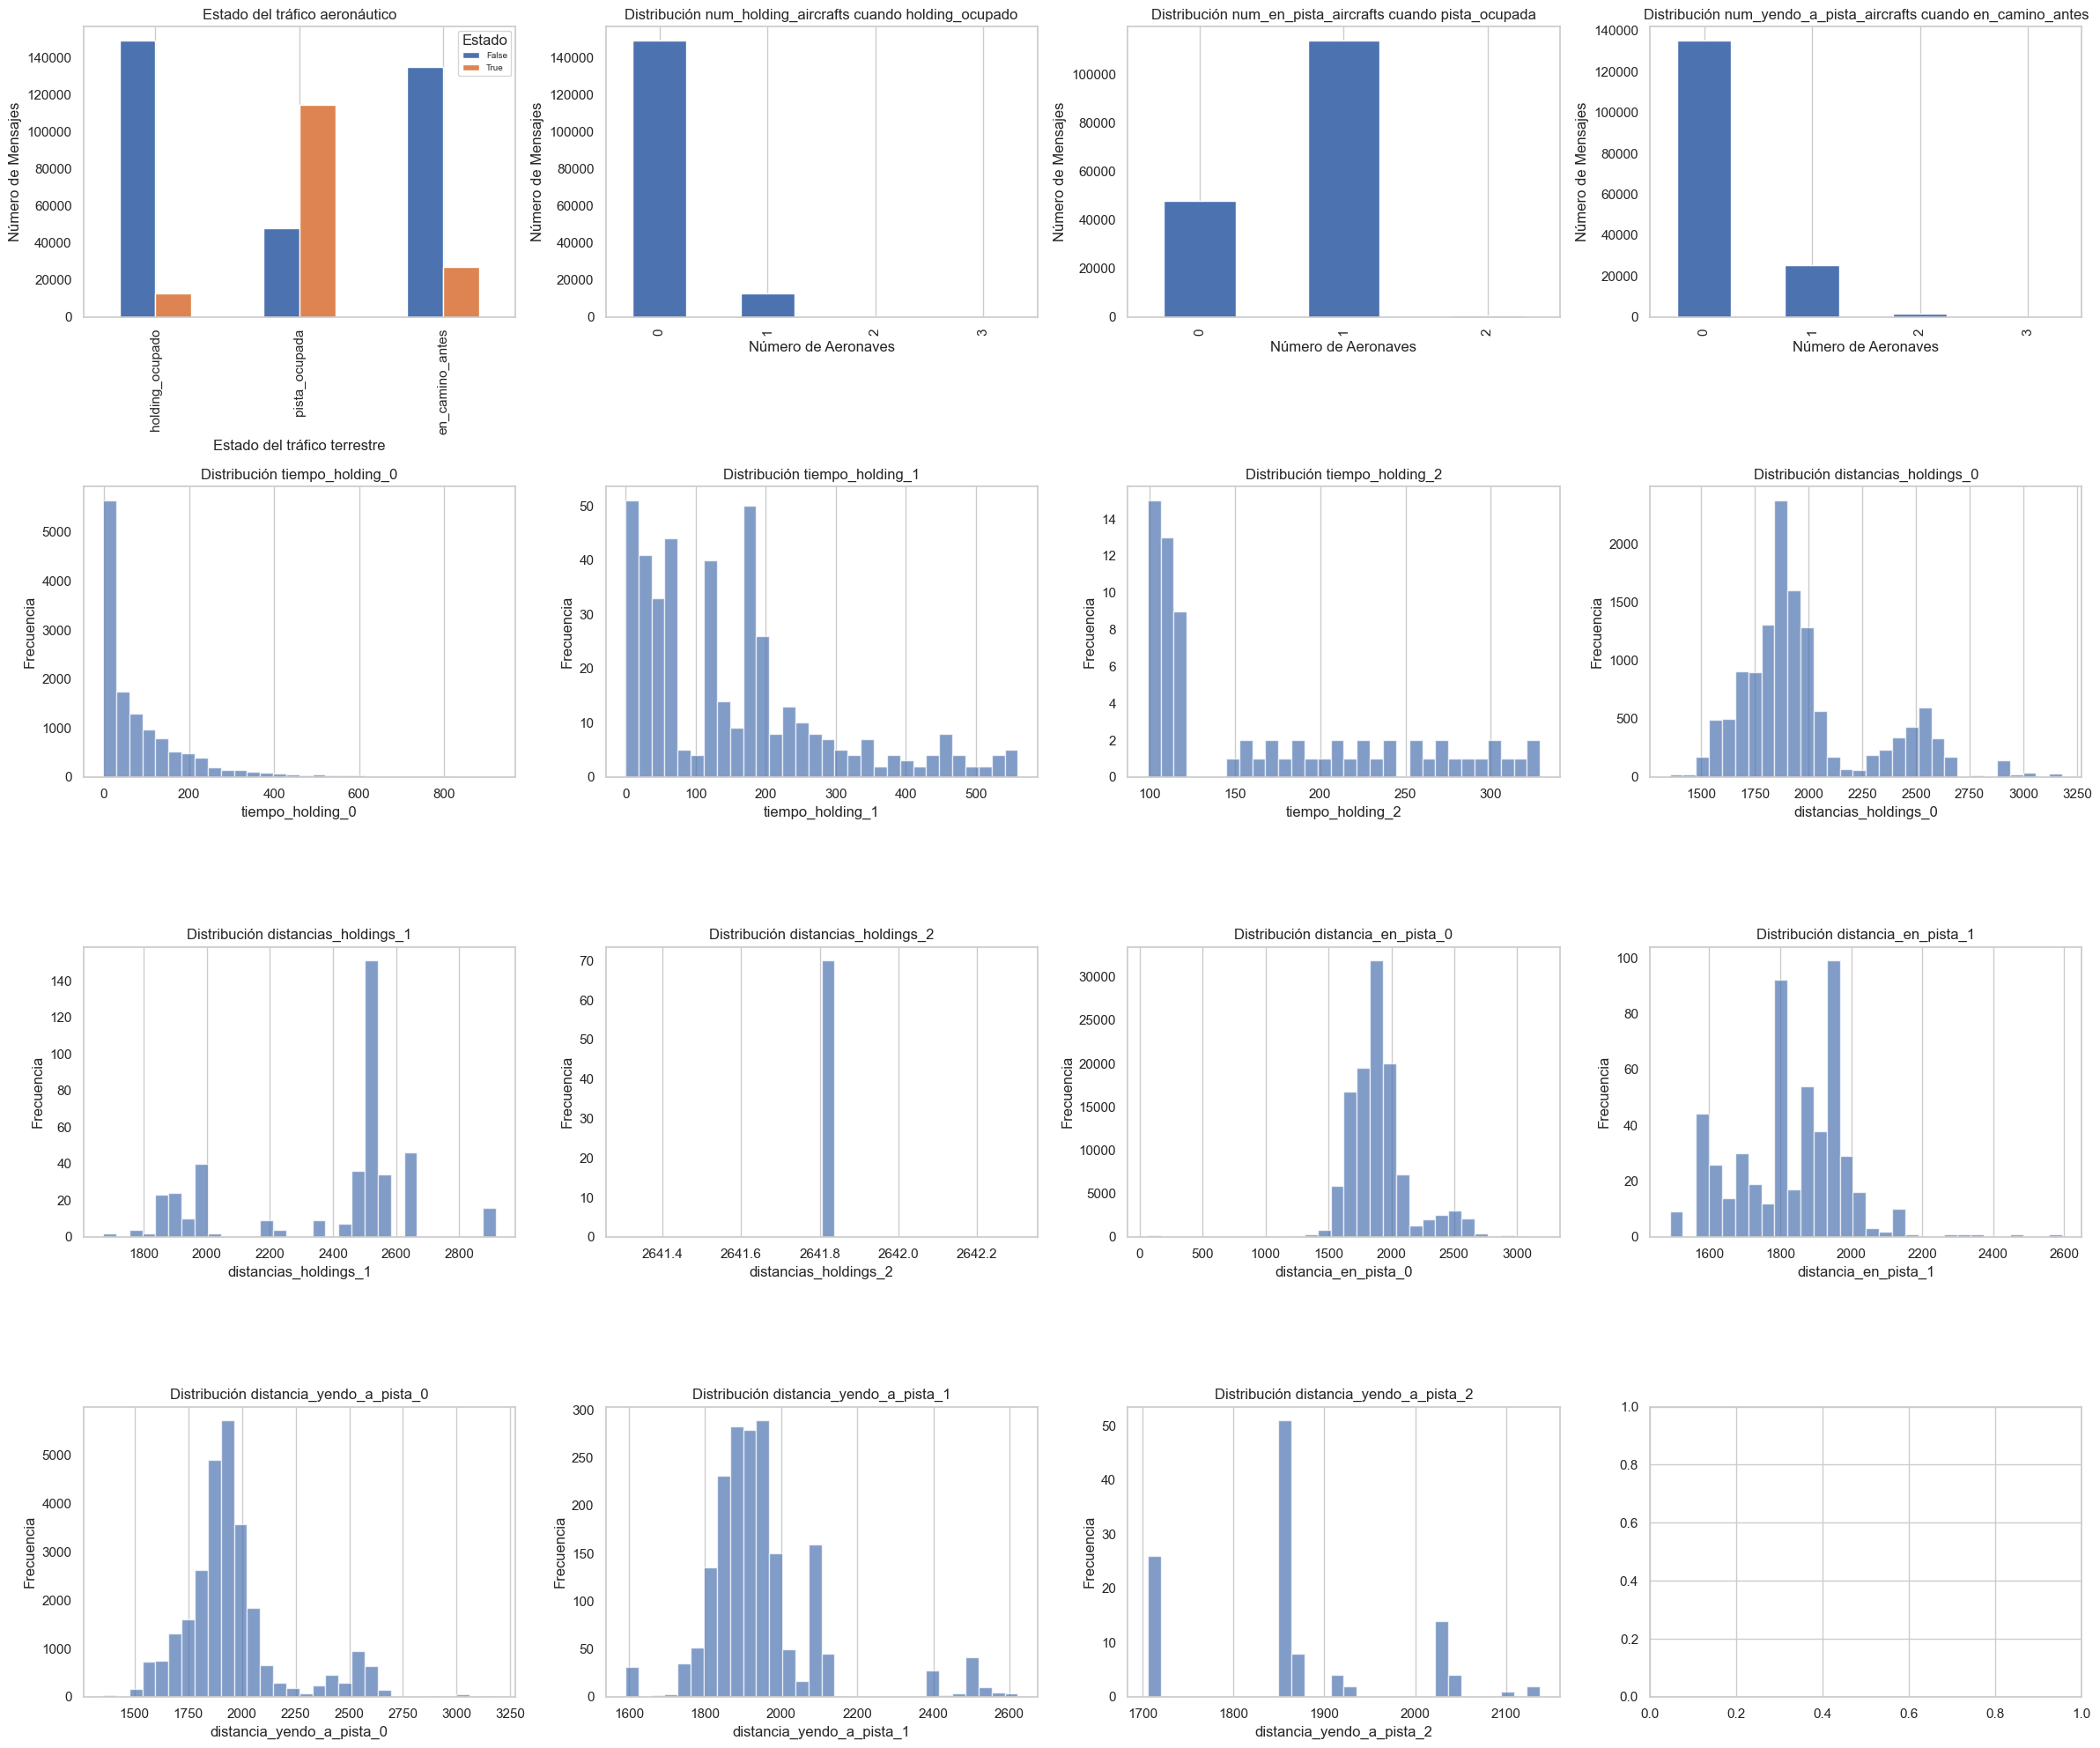

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Variables
cols1 = ['holding_ocupado', 'pista_ocupada', 'en_camino_antes', 
         "num_holding_aircrafts", "num_en_pista_aircrafts", "num_yendo_a_pista_aircrafts"]

cols2 = ['tiempo_holding_0', 'tiempo_holding_1', 'tiempo_holding_2',
         'distancias_holdings_0', 'distancias_holdings_1', 'distancias_holdings_2',
         'distancia_en_pista_0', 'distancia_en_pista_1',
         'distancia_yendo_a_pista_0', 'distancia_yendo_a_pista_1', 'distancia_yendo_a_pista_2']

aux = df4[cols1 + cols2 + ["holding_point_id", "runway"]]

# ---------------------------
# Gráficos de Estados Booleanos
# ---------------------------
data = []
for col in ['holding_ocupado', 'pista_ocupada', 'en_camino_antes']:
    counts = aux[col].value_counts()
    data.append({
        "columna": col,
        False: counts.get(False, 0),  # get para evitar error si no existe
        True: counts.get(True, 0)
    })

data_estado = pd.DataFrame(data).set_index("columna")

# Crear figura general
fig, axes = plt.subplots(4, 4, figsize=(24, 20))  # 4 filas x 4 columnas
axes = axes.flatten()  # aplanar para acceso fácil como lista

# Primer gráfico: Estado True/False
data_estado.plot(kind="bar", ax=axes[0])
axes[0].set_title("Estado del tráfico aeronáutico")
axes[0].set_xlabel("Estado del tráfico terrestre")
axes[0].set_ylabel("Número de Mensajes")
axes[0].legend(title="Estado", fontsize=7)
axes[0].grid(axis="y")

# Gráficos de número de aeronaves cuando hay ocupación o movimiento
estado_a_numero = {
    "holding_ocupado": "num_holding_aircrafts",
    "pista_ocupada": "num_en_pista_aircrafts",
    "en_camino_antes": "num_yendo_a_pista_aircrafts"
}

i = 1
for estado, columna_num in estado_a_numero.items():
    #temp = aux[aux[estado] == True]
    #temp[columna_num].astype(int).value_counts().sort_index().plot(kind="bar", ax=axes[i])
    aux[columna_num].astype(int).value_counts().sort_index().plot(kind="bar", ax=axes[i])
    
    axes[i].set_title(f"Distribución {columna_num} cuando {estado}")
    axes[i].set_xlabel("Número de Aeronaves")
    axes[i].set_ylabel("Número de Mensajes")
    axes[i].grid(axis="y")
    i += 1

# ---------------------------
# Gráficos de Distancias y Tiempos
# ---------------------------

for feature in cols2:
    aux[aux[feature]!=-1][feature].dropna().plot(kind="hist", bins=30, alpha=0.7, ax=axes[i])
    axes[i].set_title(f"Distribución {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frecuencia")
    axes[i].grid(axis="y")
    i += 1

# Ajustes finales
plt.tight_layout()
plt.show()


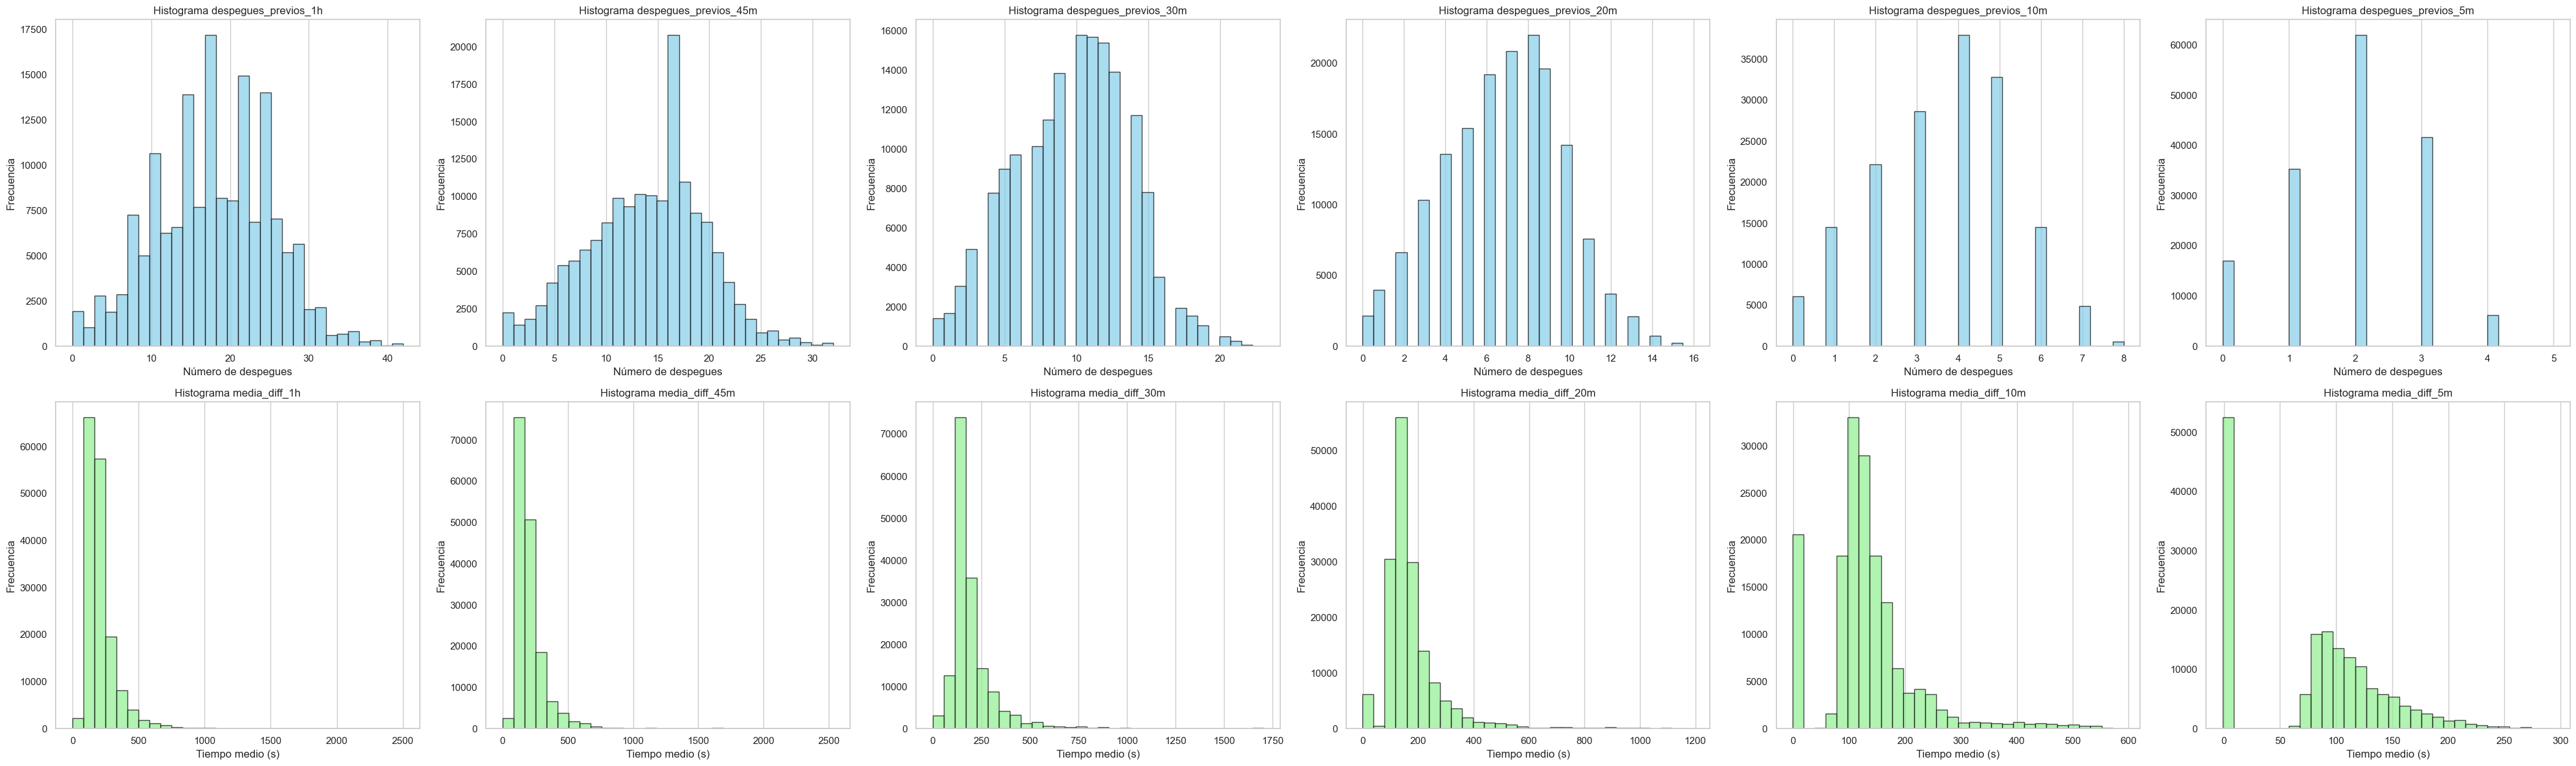

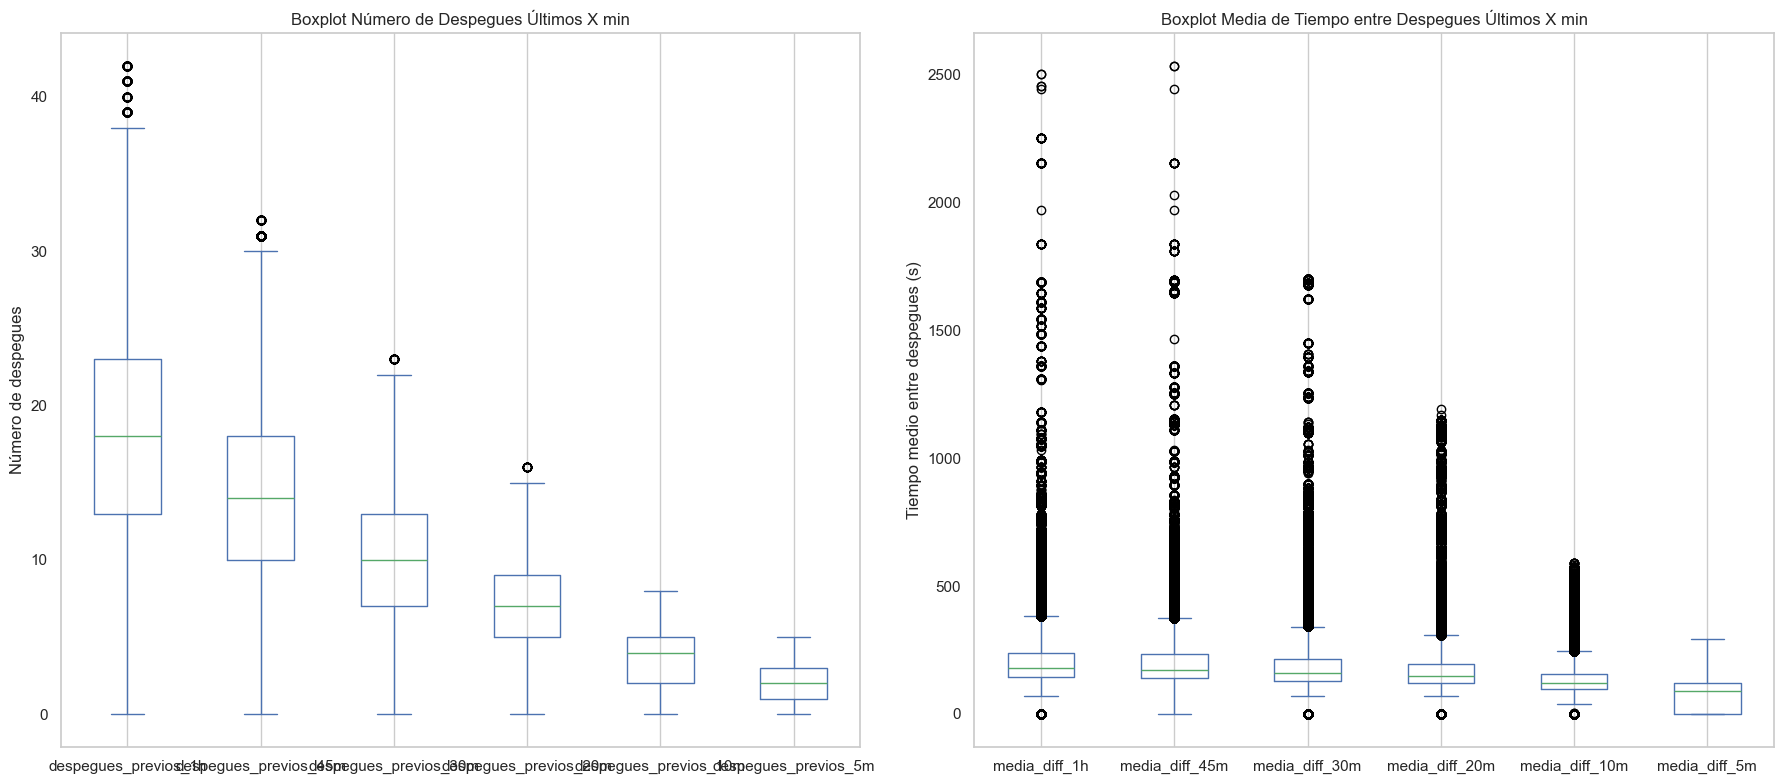

In [82]:
import pandas as pd
import matplotlib.pyplot as plt

# Columnas que nos interesan
cols_despegues = ['despegues_previos_1h', 'despegues_previos_45m', 'despegues_previos_30m',
                  'despegues_previos_20m', 'despegues_previos_10m', 'despegues_previos_5m']

cols_diff = ['media_diff_1h', 'media_diff_45m', 'media_diff_30m', 'media_diff_20m',
             'media_diff_10m', "media_diff_5m"]

# Asumiendo que tienes un DataFrame llamado df4
# Puedes adaptarlo a tu caso real

# ------------------------------
# Crear figura y ejes
# ------------------------------

fig, axes = plt.subplots(2, 6, figsize=(40, 12))  # 3 filas x 4 columnas
axes = axes.flatten()

# ------------------------------
# Histograma de número de despegues
# ------------------------------

for i, col in enumerate(cols_despegues):
    df4[col].dropna().plot(kind="hist", bins=30, alpha=0.7, ax=axes[i], color="skyblue", edgecolor="black")
    axes[i].set_title(f"Histograma {col}")
    axes[i].set_xlabel("Número de despegues")
    axes[i].set_ylabel("Frecuencia")
    axes[i].grid(axis="y")

# ------------------------------
# Histograma de tiempo medio entre despegues
# ------------------------------

for i, col in enumerate(cols_diff, start=len(cols_despegues)):
    df4[col].dropna().plot(kind="hist", bins=30, alpha=0.7, ax=axes[i], color="lightgreen", edgecolor="black")
    axes[i].set_title(f"Histograma {col}")
    axes[i].set_xlabel("Tiempo medio (s)")
    axes[i].set_ylabel("Frecuencia")
    axes[i].grid(axis="y")

# ------------------------------
# Ajustes finales
# ------------------------------
plt.tight_layout()
plt.show()

# ------------------------------
# Ahora hacemos boxplots para comparar
# ------------------------------

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Boxplot número de despegues
df4[cols_despegues].plot(kind="box", ax=axes[0])
axes[0].set_title("Boxplot Número de Despegues Últimos X min")
axes[0].set_ylabel("Número de despegues")
axes[0].grid(axis="y")

# Boxplot media de tiempos entre despegues
df4[cols_diff].plot(kind="box", ax=axes[1])
axes[1].set_title("Boxplot Media de Tiempo entre Despegues Últimos X min")
axes[1].set_ylabel("Tiempo medio entre despegues (s)")
axes[1].grid(axis="y")

plt.tight_layout()
plt.show()


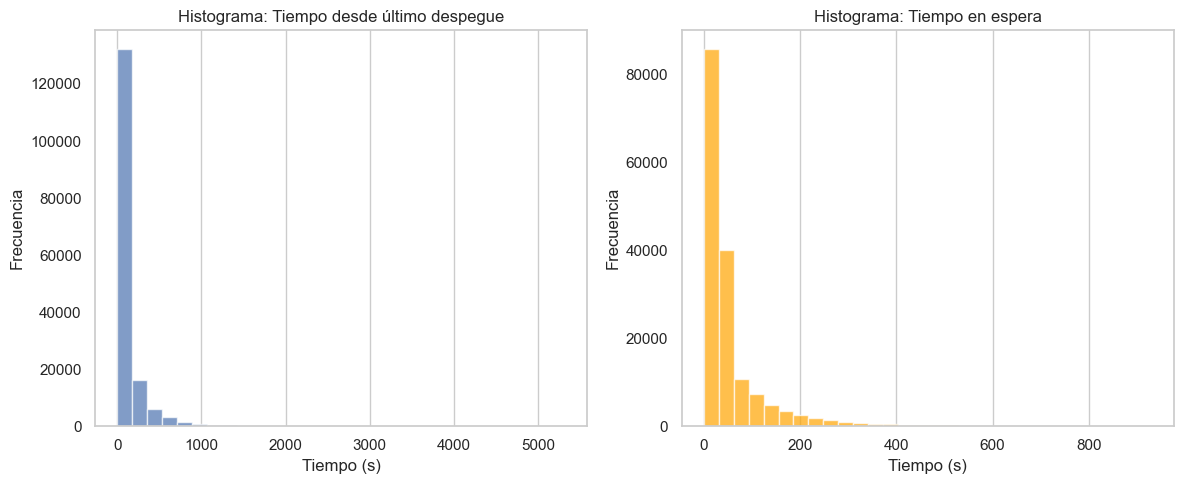

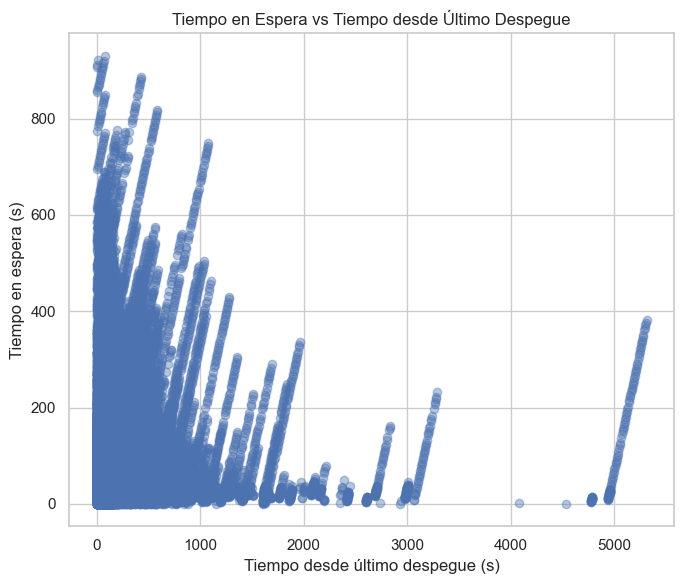

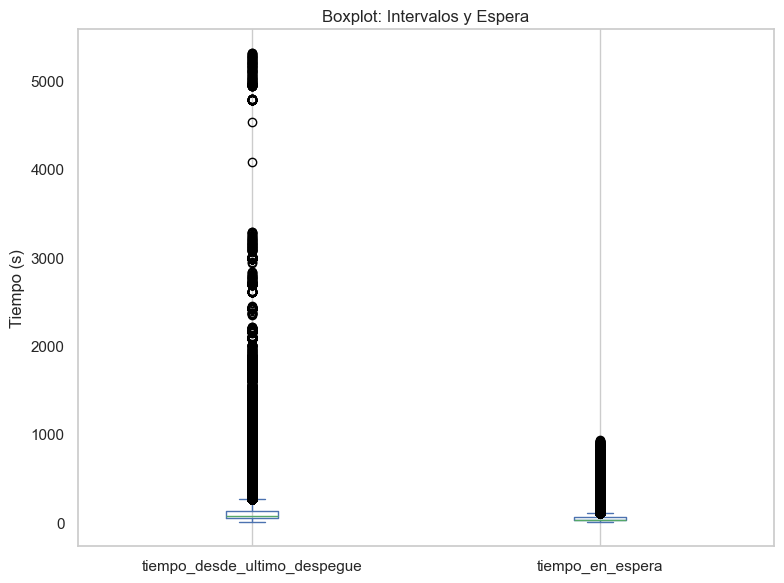

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

# Asume que tu DataFrame se llama df
# y ya contiene las columnas:
# 'tiempo_desde_ultimo_despegue' y 'tiempo_en_espera'

# 1) Histogramas lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df['tiempo_desde_ultimo_despegue'].dropna().plot(
    kind='hist', bins=30, alpha=0.7, ax=axes[0]
)
axes[0].set_title('Histograma: Tiempo desde último despegue')
axes[0].set_xlabel('Tiempo (s)')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(axis='y')

df['tiempo_en_espera'].dropna().plot(
    kind='hist', bins=30, alpha=0.7, ax=axes[1], color='orange'
)
axes[1].set_title('Histograma: Tiempo en espera')
axes[1].set_xlabel('Tiempo (s)')
axes[1].set_ylabel('Frecuencia')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

# 2) Scatter plot: relación entre ambas
plt.figure(figsize=(7, 6))
plt.scatter(
    df['tiempo_desde_ultimo_despegue'],
    df['tiempo_en_espera'],
    alpha=0.4
)
plt.title('Tiempo en Espera vs Tiempo desde Último Despegue')
plt.xlabel('Tiempo desde último despegue (s)')
plt.ylabel('Tiempo en espera (s)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) Boxplots comparativos
fig, ax = plt.subplots(figsize=(8, 6))
df[['tiempo_desde_ultimo_despegue', 'tiempo_en_espera']].plot(
    kind='box', ax=ax
)
ax.set_title('Boxplot: Intervalos y Espera')
ax.set_ylabel('Tiempo (s)')
ax.grid(axis='y')
plt.tight_layout()
plt.show()


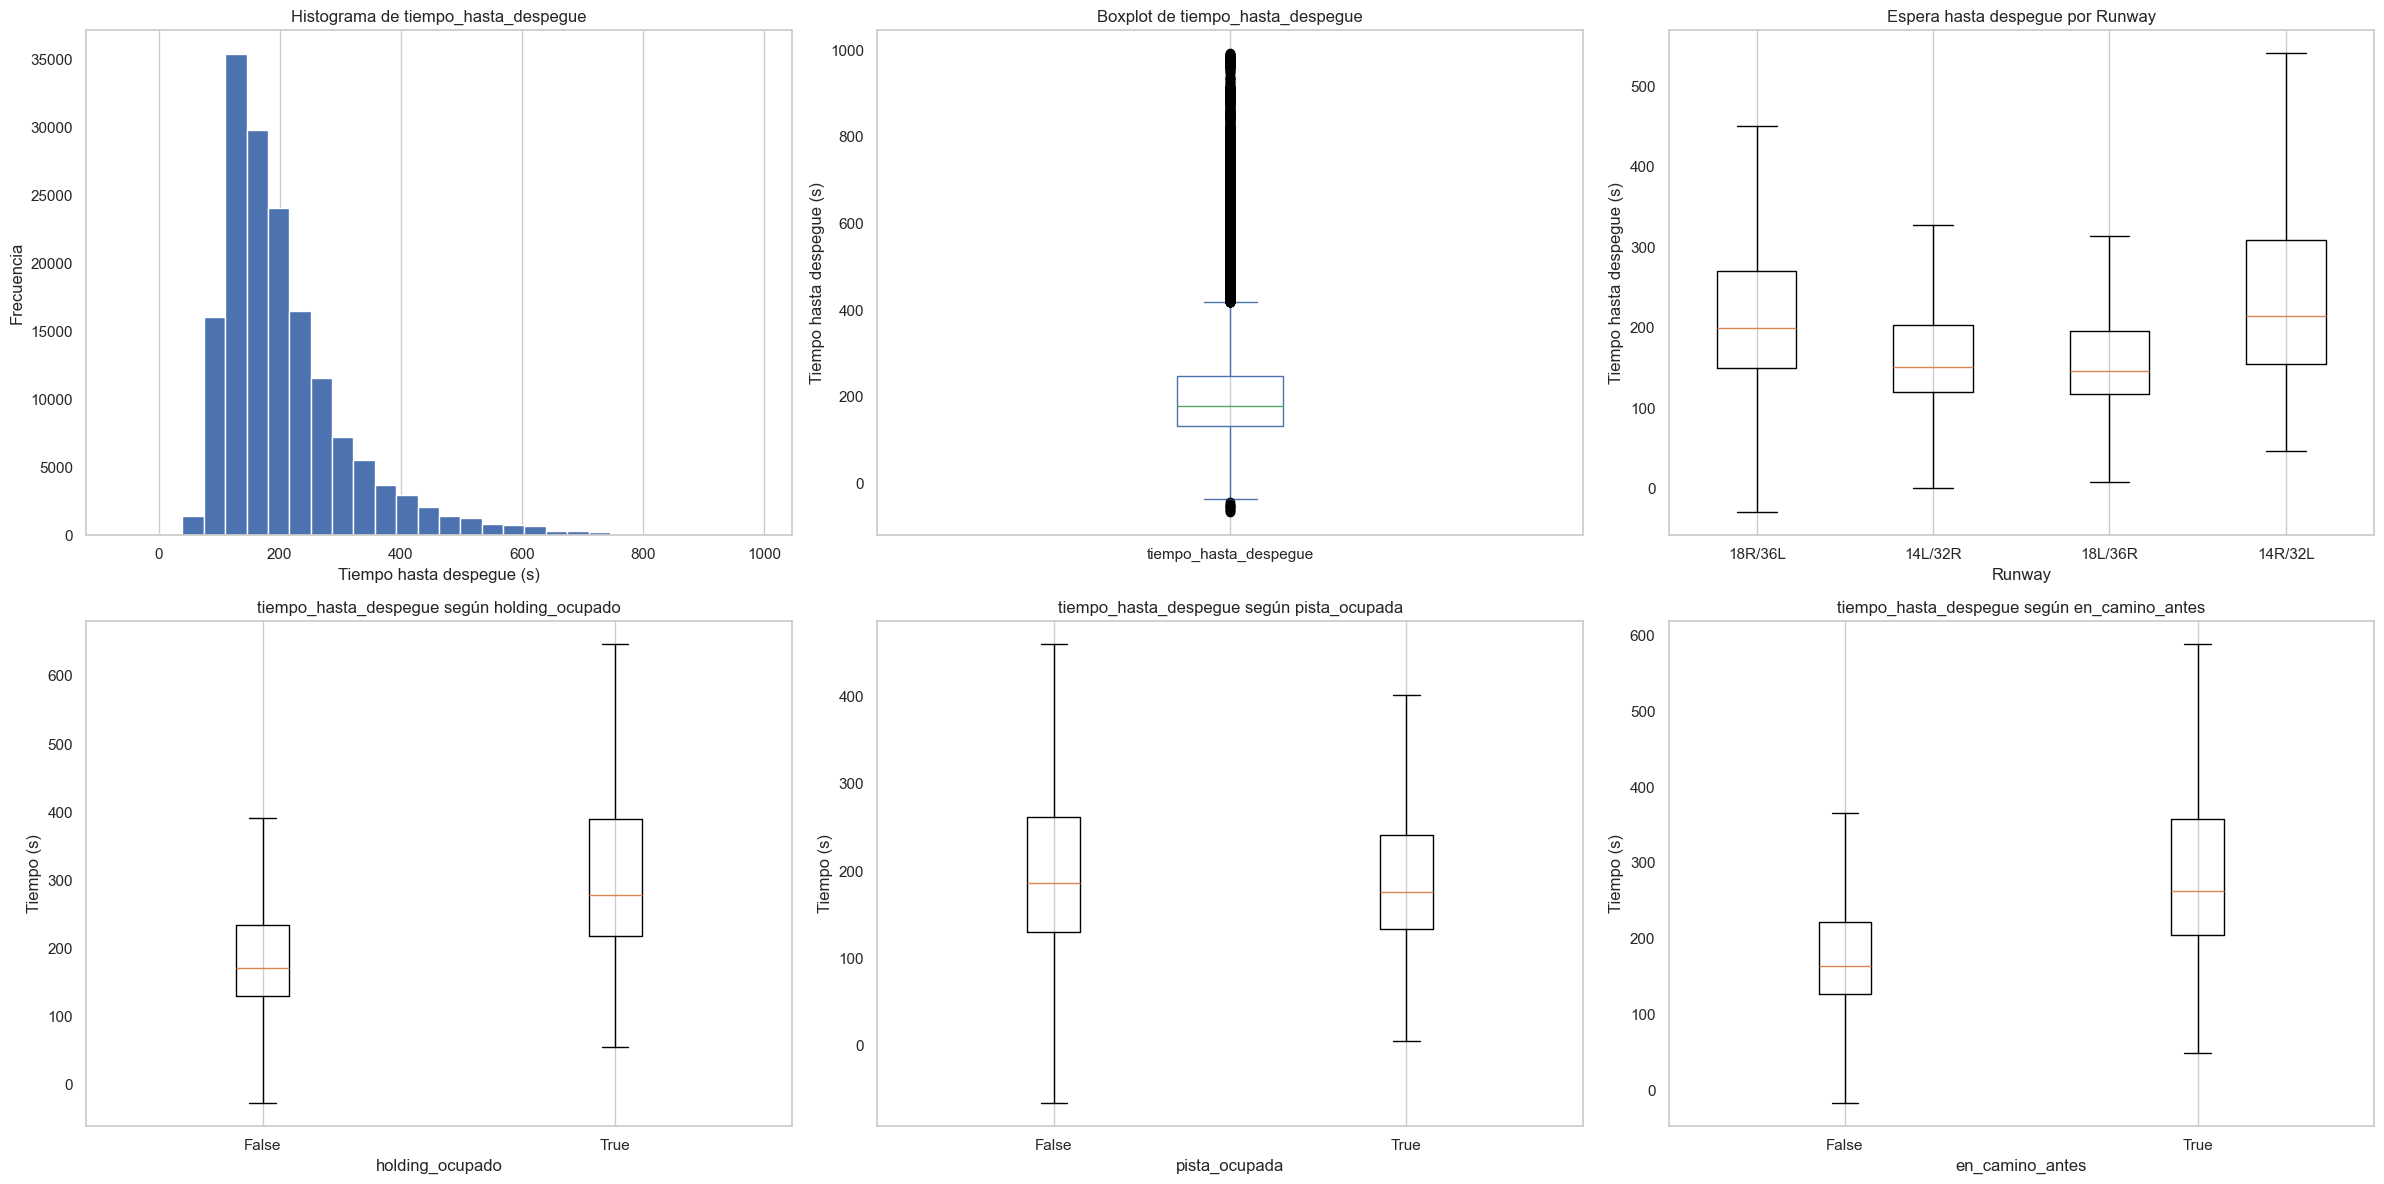

In [95]:
# --- Configuración básica ---
aux = df4  # o el nombre de tu DataFrame
response = 'tiempo_hasta_despegue'  # tu variable respuesta

# Aseguramos que esté en tipo numérico
aux[response] = pd.to_numeric(aux[response], errors='coerce')

# --- 1) Distribución global de la variable respuesta ---
fig, axes = plt.subplots(2, 3, figsize=(24, 12))
axes = axes.flatten()

# Histograma
aux[response].dropna().plot(kind='hist', bins=30, ax=axes[0])
axes[0].set_title('Histograma de tiempo_hasta_despegue')
axes[0].set_xlabel('Tiempo hasta despegue (s)')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(axis='y')

# Boxplot global
aux[response].dropna().plot(kind='box', ax=axes[1])
axes[1].set_title('Boxplot de tiempo_hasta_despegue')
axes[1].set_ylabel('Tiempo hasta despegue (s)')
axes[1].grid(axis='y')

# --- 2) Segmentación por pista (runway) ---
runways = aux['runway'].dropna().unique()
groups = [aux[aux['runway']==r][response].dropna() for r in runways]
axes[2].boxplot(groups, labels=runways, showfliers=False)
axes[2].set_title('Espera hasta despegue por Runway')
axes[2].set_xlabel('Runway')
axes[2].set_ylabel('Tiempo hasta despegue (s)')
axes[2].grid(axis='y')

# --- 3) Segmentación por estado de tráfico (holding_ocupado, pista_ocupada) ---
for idx, col in enumerate(['holding_ocupado','pista_ocupada', "en_camino_antes"], start=3):
    states = [aux[aux[col]==s][response].dropna() for s in [False, True]]
    axes[idx].boxplot(states, labels=['False','True'], showfliers=False)
    axes[idx].set_title(f'{response} según {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Tiempo (s)')
    axes[idx].grid(axis='y')

plt.tight_layout()
plt.show()


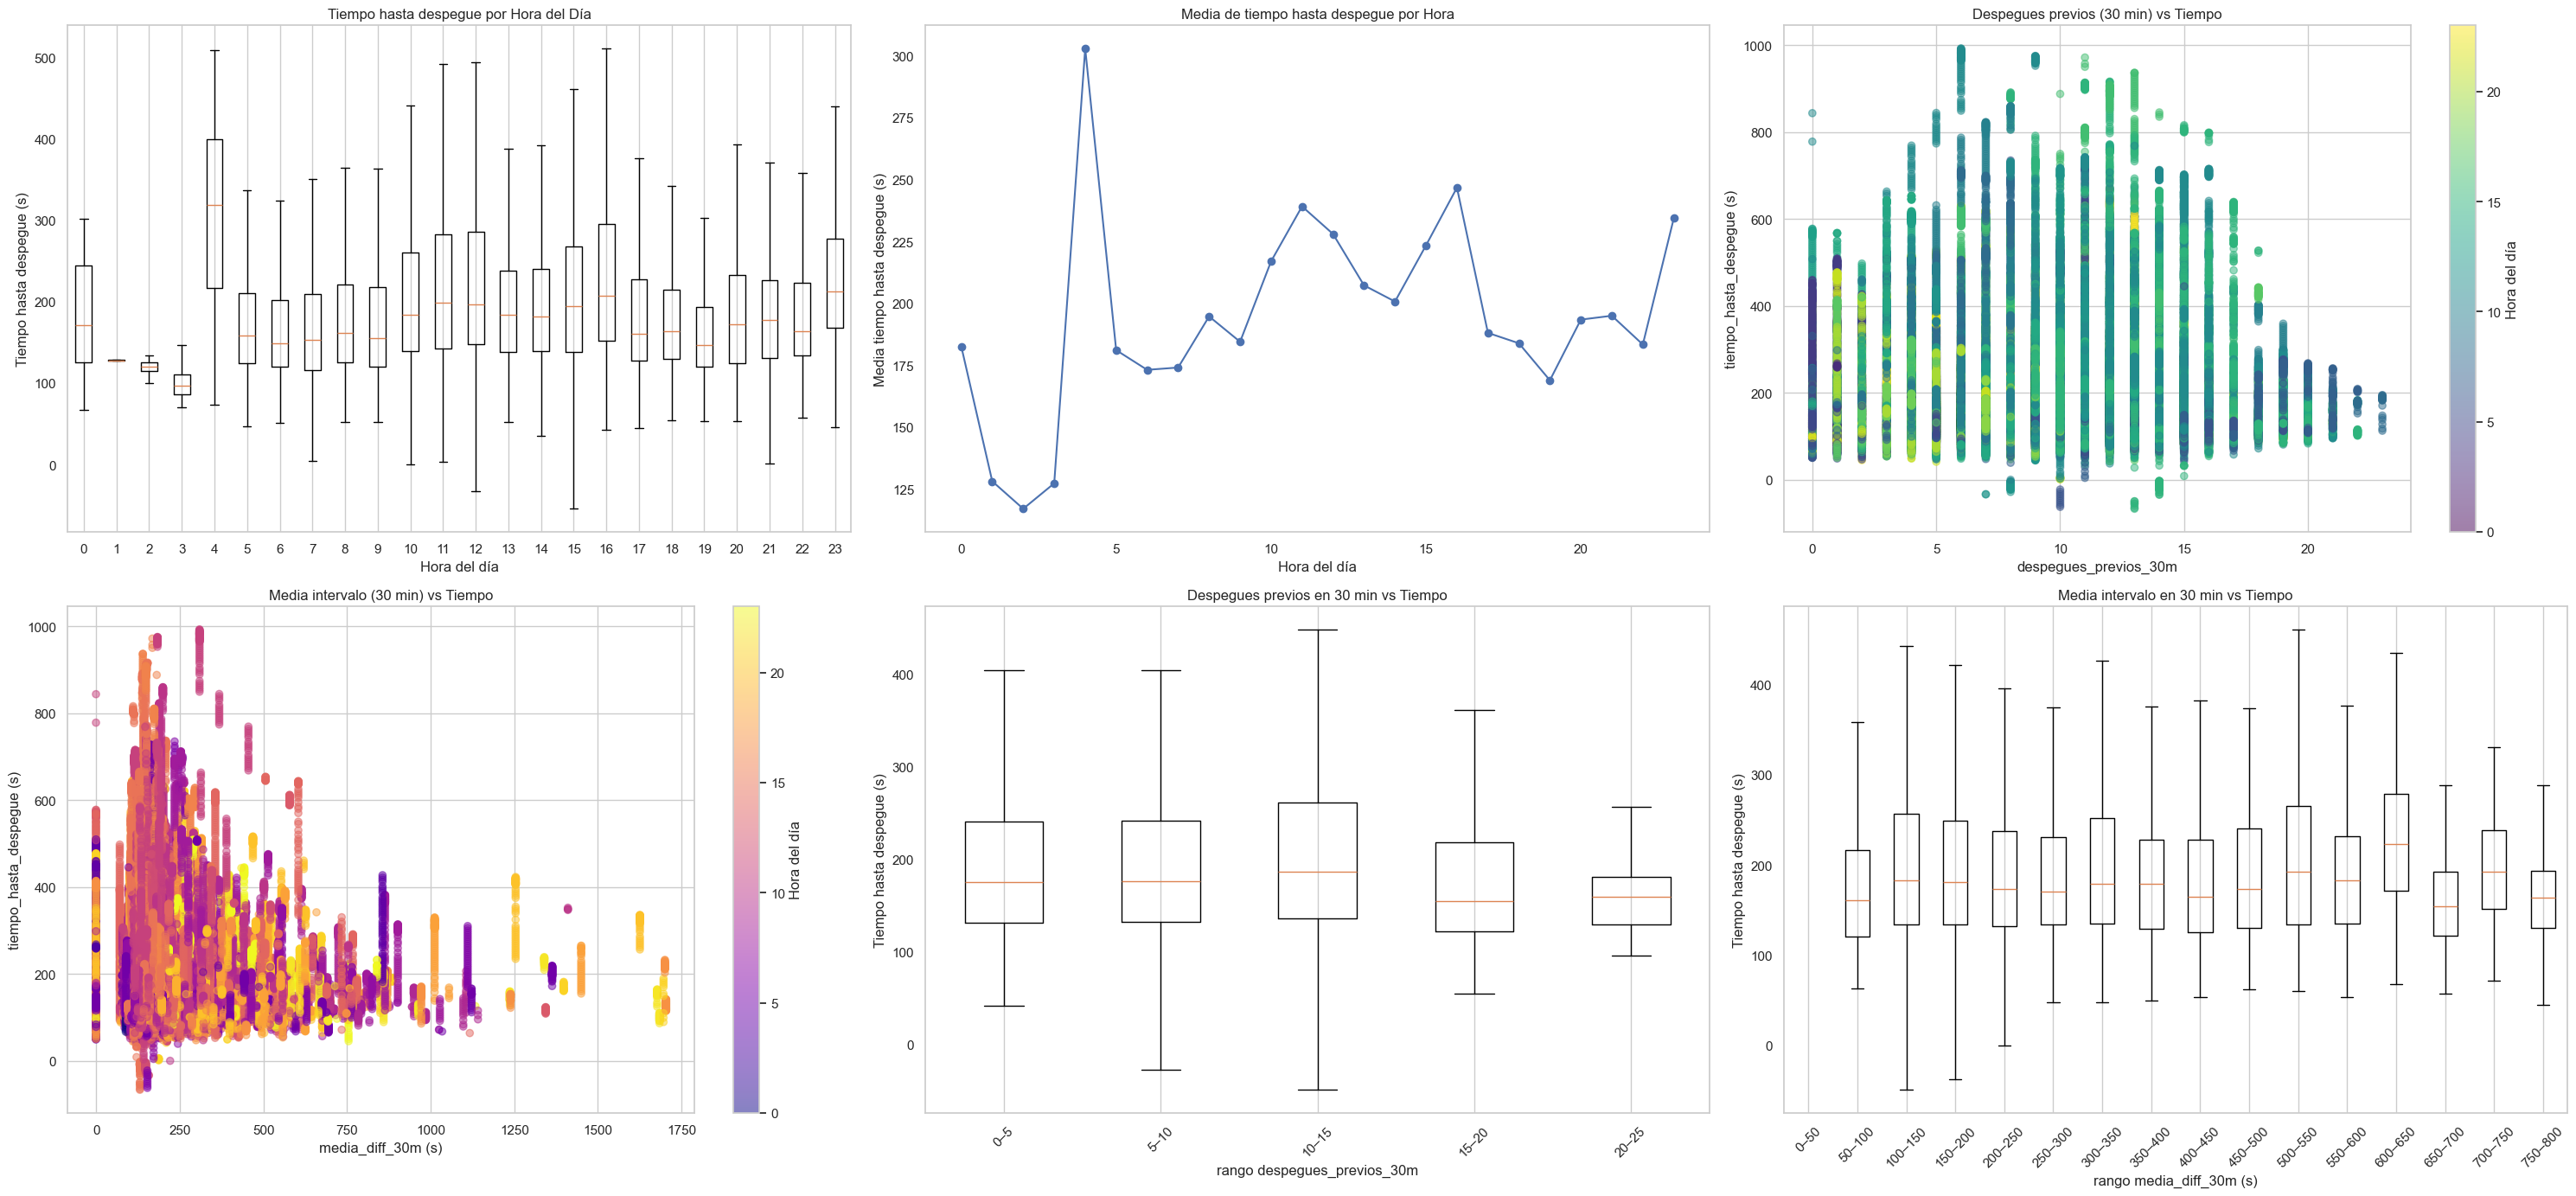

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

aux = df4.copy()              # o el nombre de tu DataFrame
response = 'tiempo_hasta_despegue'

# Aseguramos tipo numérico y creamos la columna hour si no existe
aux[response] = pd.to_numeric(aux[response], errors='coerce')
aux["hour"] = aux["hour"].astype(int)

# Preparación de datos
hours = sorted(aux['hour'].dropna().unique())
groups_hour = [aux[aux['hour']==h][response].dropna() for h in hours]
mean_by_hour = aux.groupby('hour')[response].mean().reindex(hours)

bins_des = list(range(0, int(aux['despegues_previos_30m'].max())+5, 5))
aux['bin_des30'] = pd.cut(aux['despegues_previos_30m'], bins=bins_des)
groups_bin_des30 = [grp[response].dropna() for _, grp in aux.groupby('bin_des30')]

max_diff = int(aux['media_diff_30m'].quantile(0.99))
bins_diff = list(range(0, max_diff+50, 50))
aux['bin_diff30'] = pd.cut(aux['media_diff_30m'], bins=bins_diff)
groups_bin_diff30 = [grp[response].dropna() for _, grp in aux.groupby('bin_diff30')]

# Creamos los subplots 2 filas x 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(30, 14))

# 1) Boxplot de tiempo_hasta_despegue por hora del día
axes[0, 0].boxplot(groups_hour, labels=hours, showfliers=False)
axes[0, 0].set_title('Tiempo hasta despegue por Hora del Día')
axes[0, 0].set_xlabel('Hora del día')
axes[0, 0].set_ylabel('Tiempo hasta despegue (s)')
axes[0, 0].grid(axis='y')

# 2) Media de tiempo_hasta_despegue por hora (gráfico de líneas)
axes[0, 1].plot(hours, mean_by_hour, marker='o')
axes[0, 1].set_title('Media de tiempo hasta despegue por Hora')
axes[0, 1].set_xlabel('Hora del día')
axes[0, 1].set_ylabel('Media tiempo hasta despegue (s)')
axes[0, 1].grid()

# 3) Scatter: respuesta vs despegues_previos_30m, coloreado por hora
sc1 = axes[0, 2].scatter(aux['despegues_previos_30m'], aux[response],
                        c=aux['hour'], cmap='viridis', alpha=0.5)
axes[0, 2].set_title('Despegues previos (30 min) vs Tiempo')
axes[0, 2].set_xlabel('despegues_previos_30m')
axes[0, 2].set_ylabel('tiempo_hasta_despegue (s)')
axes[0, 2].grid(True)
fig.colorbar(sc1, ax=axes[0, 2], label='Hora del día')

# 4) Scatter: respuesta vs media_diff_30m, coloreado por hora
sc2 = axes[1, 0].scatter(aux['media_diff_30m'], aux[response],
                        c=aux['hour'], cmap='plasma', alpha=0.5)
axes[1, 0].set_title('Media intervalo (30 min) vs Tiempo')
axes[1, 0].set_xlabel('media_diff_30m (s)')
axes[1, 0].set_ylabel('tiempo_hasta_despegue (s)')
axes[1, 0].grid(True)
fig.colorbar(sc2, ax=axes[1, 0], label='Hora del día')

# 5) Boxplot de respuesta segmentado por bins de despegues_previos_30m
axes[1, 1].boxplot(
    groups_bin_des30,
    labels=[f"{int(interval.left)}–{int(interval.right)}"
            for interval in aux['bin_des30'].cat.categories],
    showfliers=False
)
axes[1, 1].set_title('Despegues previos en 30 min vs Tiempo')
axes[1, 1].set_xlabel('rango despegues_previos_30m')
axes[1, 1].set_ylabel('Tiempo hasta despegue (s)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y')

# 6) Boxplot de respuesta segmentado por bins de media_diff_30m
axes[1, 2].boxplot(
    groups_bin_diff30,
    labels=[f"{int(interval.left)}–{int(interval.right)}"
            for interval in aux['bin_diff30'].cat.categories],
    showfliers=False
)
axes[1, 2].set_title('Media intervalo en 30 min vs Tiempo')
axes[1, 2].set_xlabel('rango media_diff_30m (s)')
axes[1, 2].set_ylabel('Tiempo hasta despegue (s)')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(axis='y')

plt.tight_layout()
plt.show()


In [14]:
colsFilled1 = ['media_diff_1h', 'media_diff_45m', 'media_diff_30m', 'media_diff_20m', 'media_diff_10m', 'media_diff_5m', 'tiempo_holding_0', 'tiempo_holding_1', 'tiempo_holding_2', "tipo_avion_ultimo_despegue", 'distancias_holdings_0', 'distancias_holdings_1', 'distancias_holdings_2', 'distancia_en_pista_0', 'distancia_en_pista_1', 'distancia_yendo_a_pista_0', 'distancia_yendo_a_pista_1', 'distancia_yendo_a_pista_2', "tiempo_desde_ultimo_despegue"]

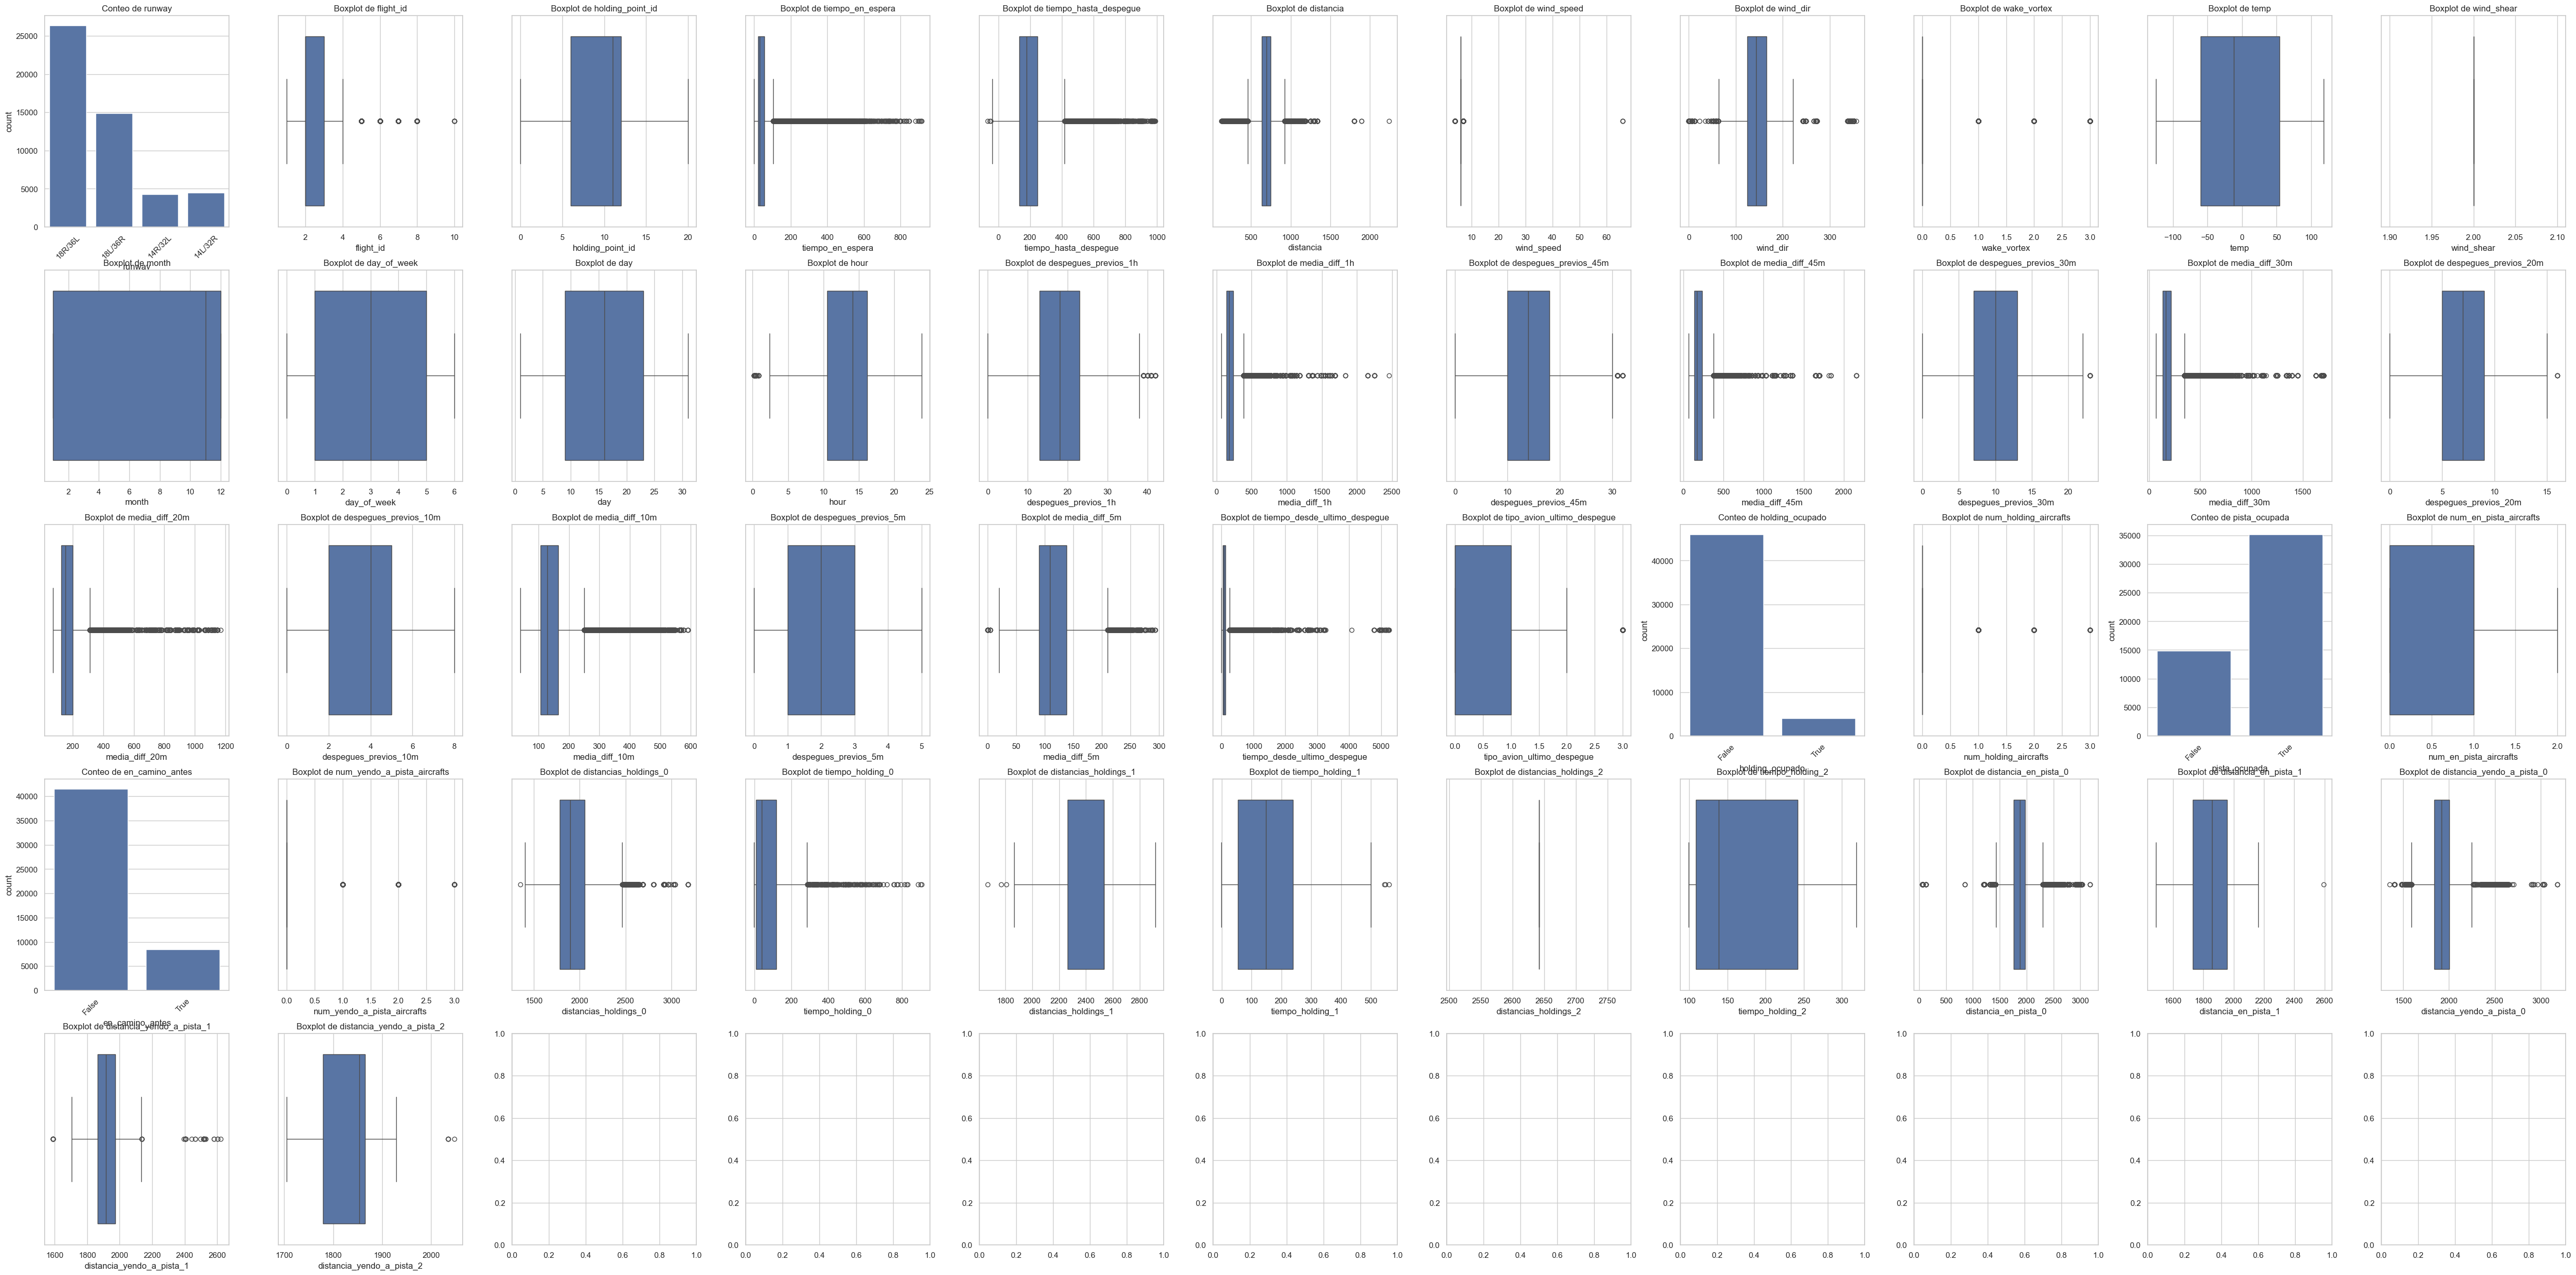

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_plot = df_sample.reset_index(drop=True)
categorical_cols = df_plot.select_dtypes(exclude=[np.number]).columns
n_rows = int(np.ceil(len(df_plot.columns) / n_cols))
sns.set(style="whitegrid")
fig, axes = plt.subplots(n_rows, n_cols, figsize=(50, n_rows * 5))
fig.tight_layout(pad=3.0)
for i, col in enumerate(df_plot.columns):
    if col in colsFilled1:
        df_tmp = df_plot[df_plot[col] != -1]
    else:
        df_tmp = df_plot.copy()
    row = i // n_cols
    col_pos = i % n_cols
    ax = axes[row, col_pos] if n_rows > 1 else axes[col_pos]
    if col in numeric_cols:
        sns.boxplot(x=df_tmp[col], ax=ax)
        ax.set_title(f'Boxplot de {col}')
    elif col in categorical_cols:
        try:
            sns.countplot(x=df_tmp[col], ax=ax)
            ax.set_title(f'Conteo de {col}')
            ax.tick_params(axis='x', rotation=45)
        except Exception as e:
            print(f"Error plotting {col}: {e}")
    else:
        ax.axis('off')
plt.show()

In [16]:
df5 = df3.drop_duplicates(subset=["icao", "flight_id", "day", "month"])

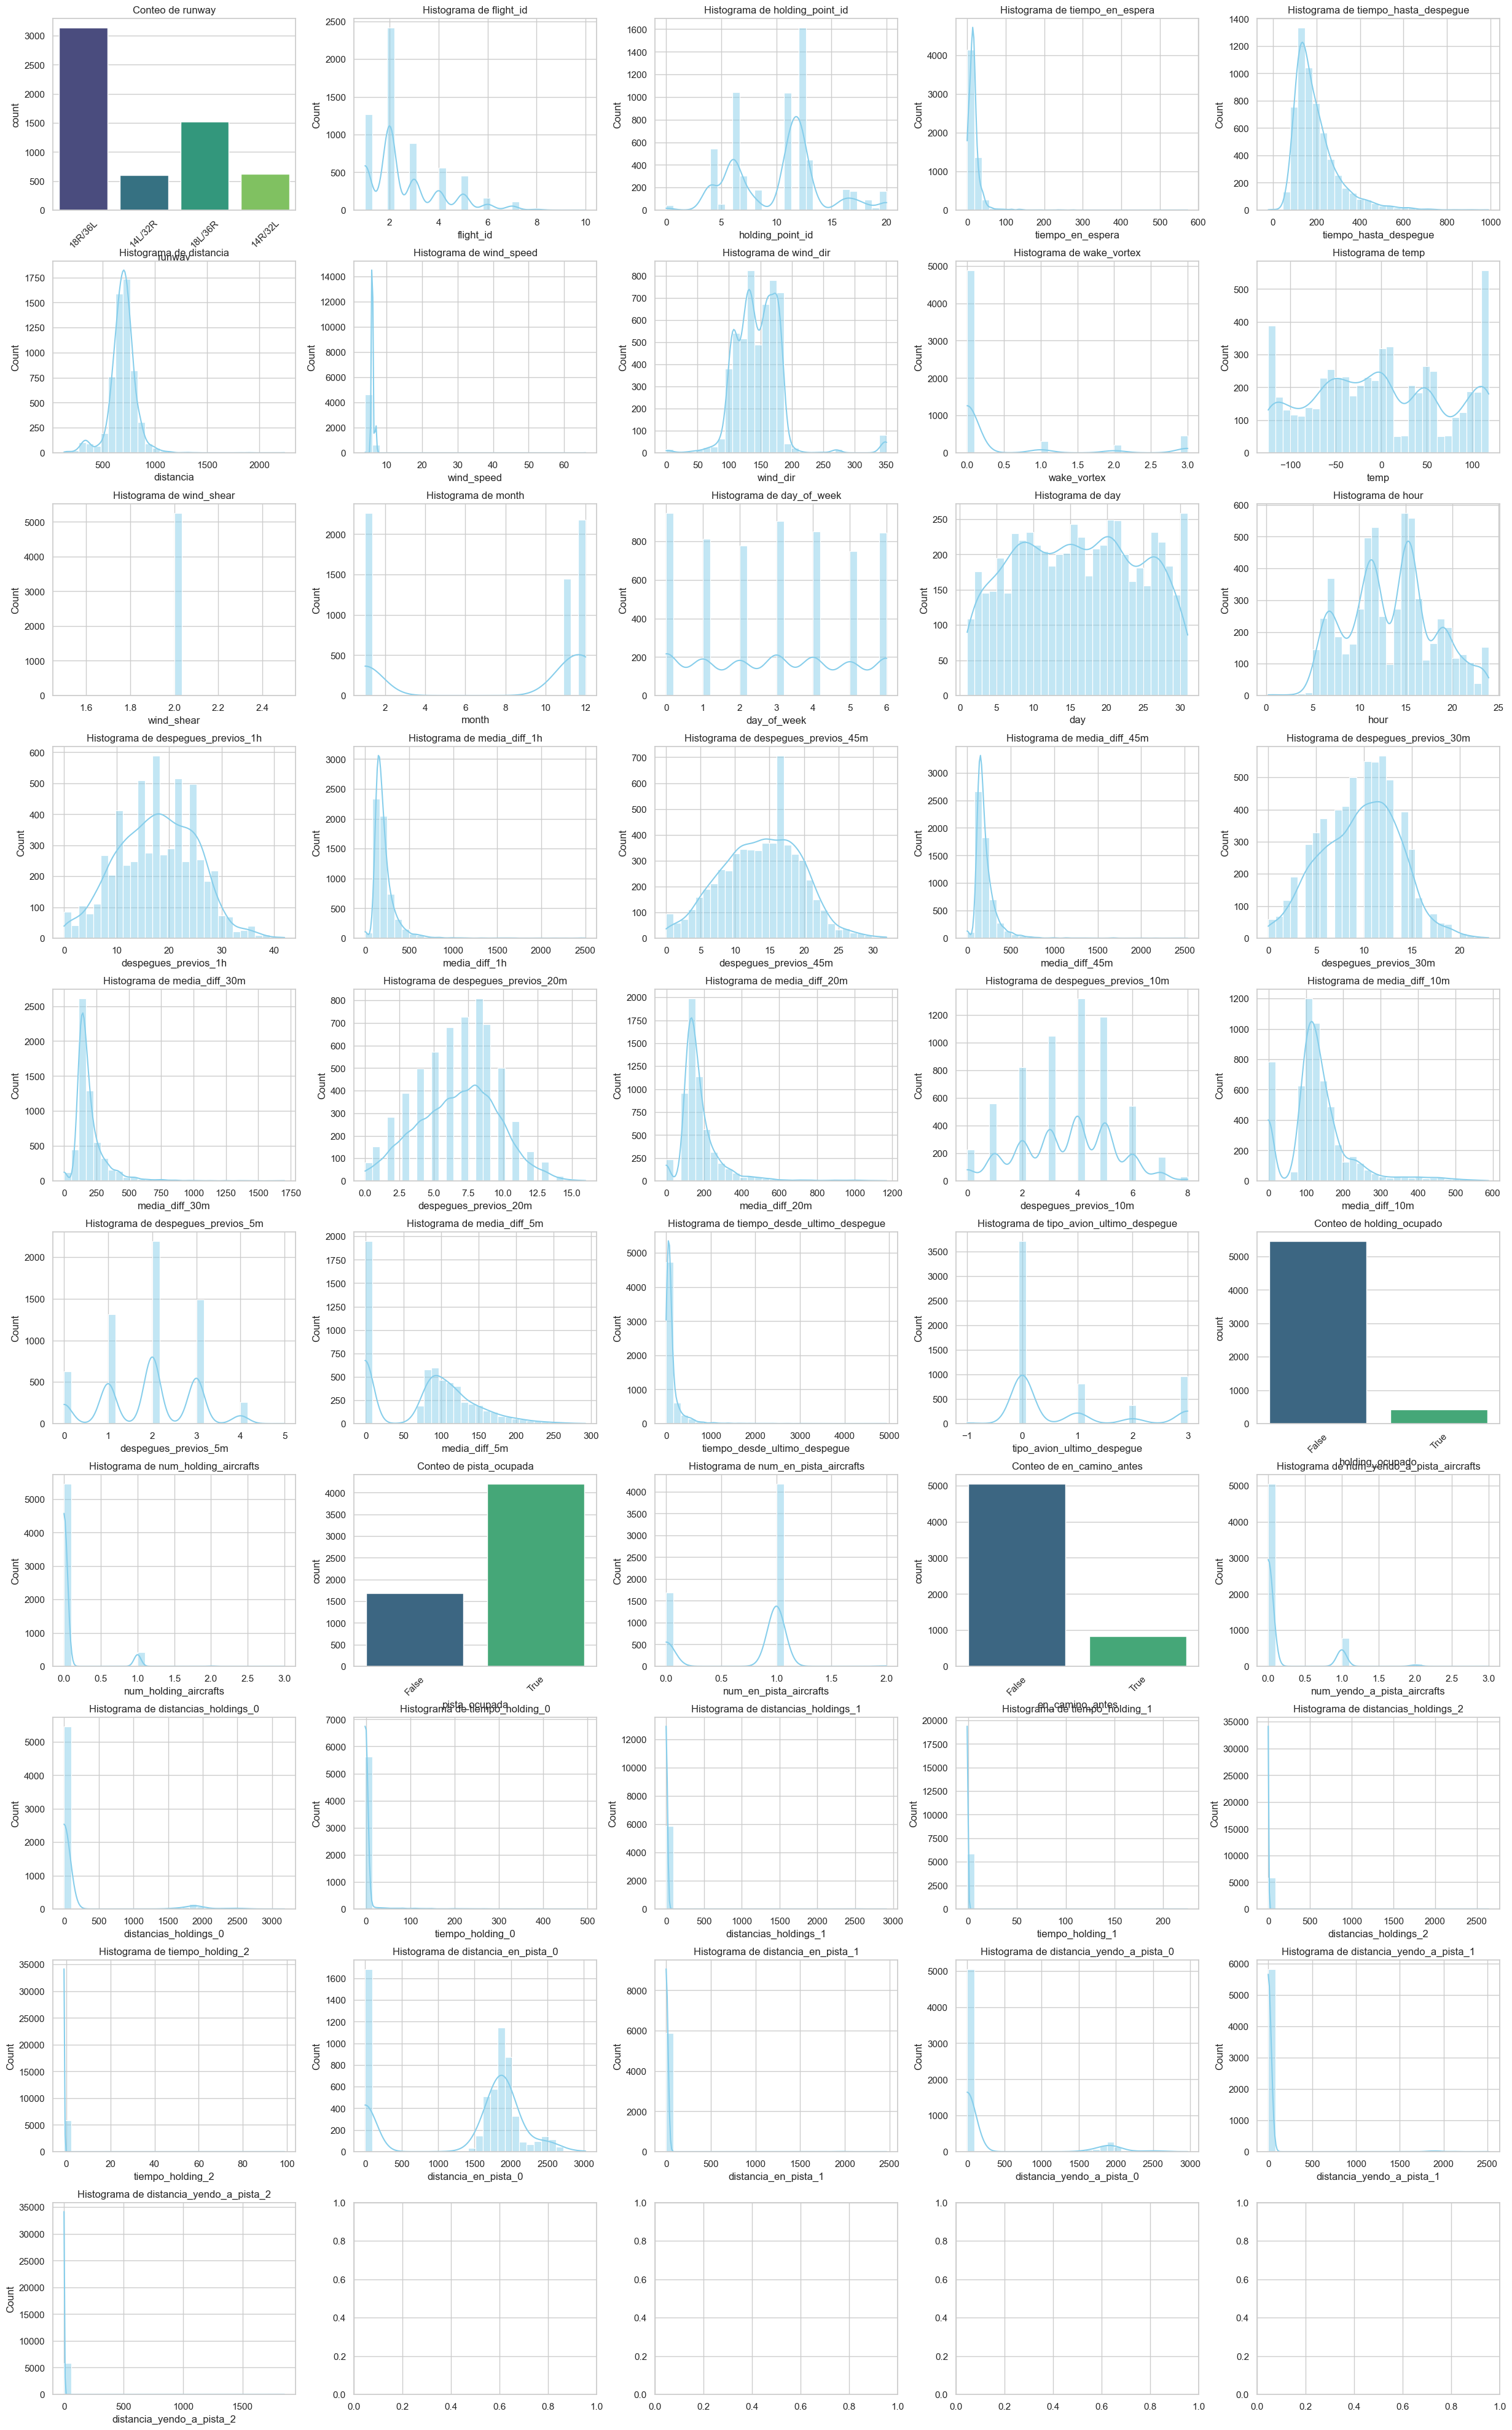

In [17]:
sns.set(style="whitegrid")
df_sample = df5.drop(["ts", "icao"], axis=1)
numeric_cols = df_sample.select_dtypes(include=[np.number]).columns
categorical_cols = df_sample.select_dtypes(exclude=[np.number]).columns
n_cols = 5
n_rows = int(np.ceil(len(df_sample.columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, n_rows * 4))
fig.tight_layout(pad=3.0)
for i, col in enumerate(df_sample.columns):
    row = i // n_cols
    col_pos = i % n_cols
    if n_rows == 1:
        ax = axes[col_pos]
    else:
        ax = axes[row, col_pos]
    if col in numeric_cols:
        try:
            sns.histplot(df_sample[col], kde=True, ax=ax, color='skyblue', bins=30)
            ax.set_title(f'Histograma de {col}')
        except:
            print(col)
    elif col in categorical_cols:
        try:
            sns.countplot(data=df_sample, x=col, ax=ax, palette='viridis')
            ax.set_title(f'Conteo de {col}')
            ax.tick_params(axis='x', rotation=45)
        except: 
            print(col)
    else:
        ax.axis('off')
plt.show()

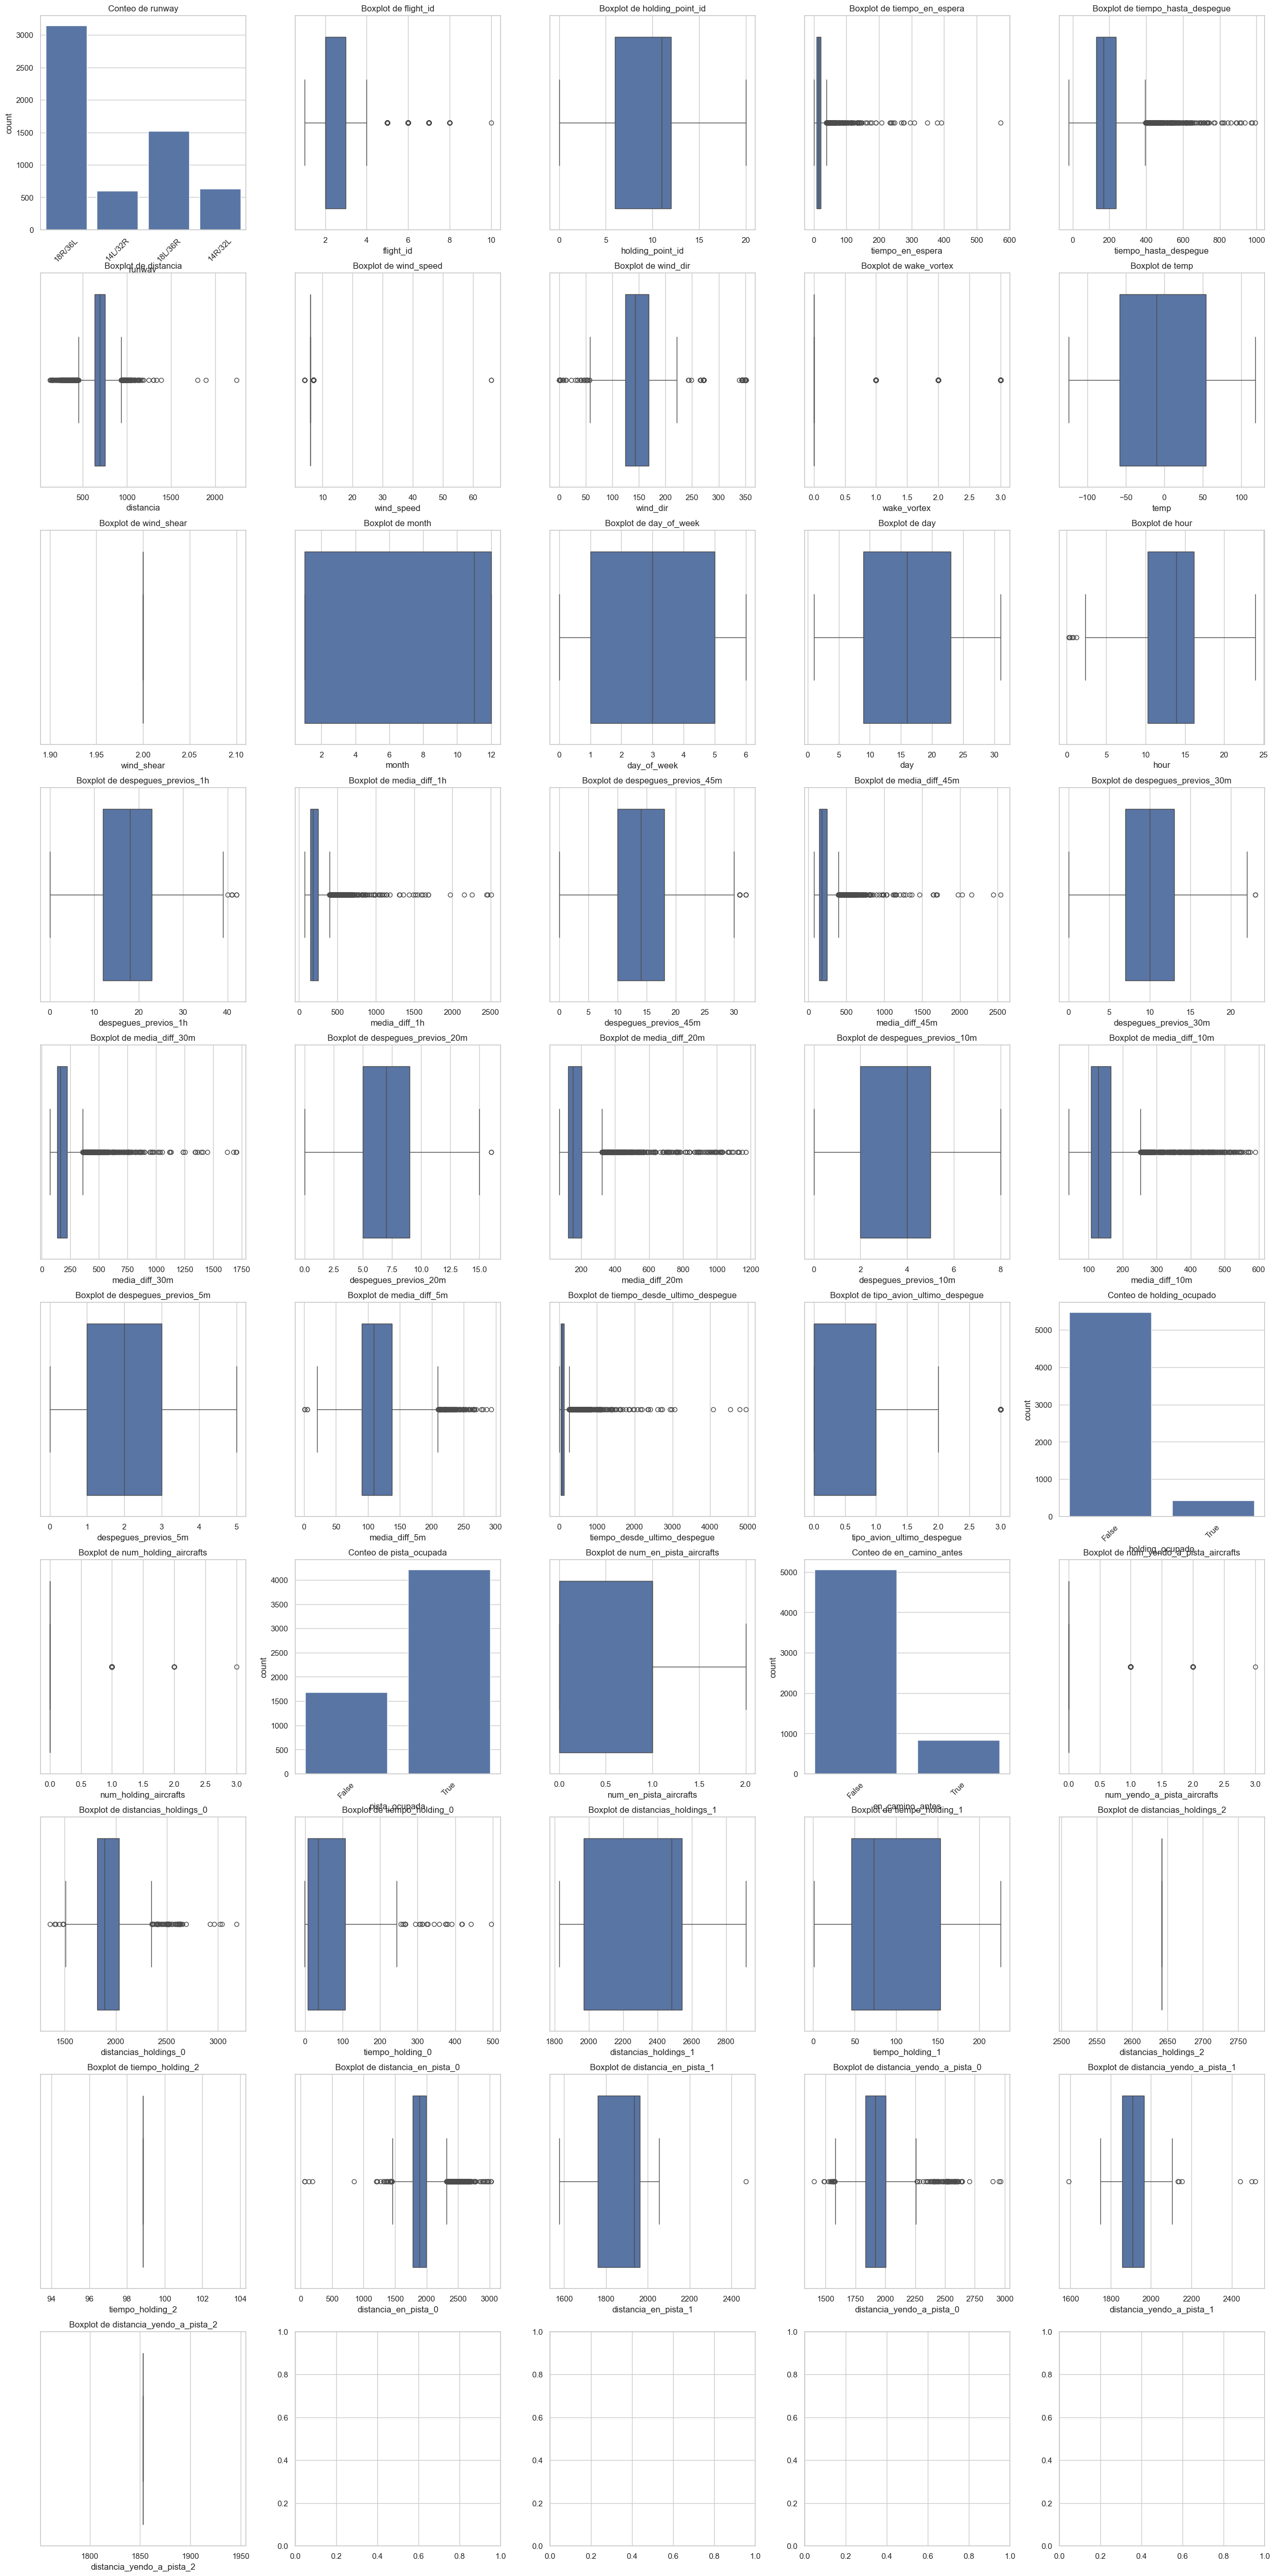

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_plot = df_sample.reset_index(drop=True)
numeric_cols = df_plot.select_dtypes(include=[np.number]).columns
categorical_cols = df_plot.select_dtypes(exclude=[np.number]).columns
n_cols = 5
n_rows = int(np.ceil(len(df_plot.columns) / n_cols))
sns.set(style="whitegrid")
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, n_rows * 5))
fig.tight_layout(pad=3.0)

for i, col in enumerate(df_plot.columns):
    if col in colsFilled1:
        df_tmp = df_plot[df_plot[col] != -1]
    else:
        df_tmp = df_plot.copy()
    row = i // n_cols
    col_pos = i % n_cols
    ax = axes[row, col_pos] if n_rows > 1 else axes[col_pos]
    if col in numeric_cols:
        sns.boxplot(x=df_tmp[col], ax=ax)
        ax.set_title(f'Boxplot de {col}')
    elif col in categorical_cols:
        try:
            sns.countplot(x=df_tmp[col], ax=ax)
            ax.set_title(f'Conteo de {col}')
            ax.tick_params(axis='x', rotation=45)
        except: 
            print(col)
    else:
        ax.axis('off')
plt.show()


In [19]:
df_final = df3.copy()
df_final

ts    icao   runway  flight_id  holding_point_id  \
0    2024-11-07 13:35:34.633  02010D  18R/36L          2              12.0   
1    2024-11-07 13:35:35.211  02010D  18R/36L          2              12.0   
2    2024-11-07 13:35:35.661  02010D  18R/36L          2              12.0   
3    2024-11-07 13:35:36.177  02010D  18R/36L          2              12.0   
4    2024-11-07 13:35:36.655  02010D  18R/36L          2              12.0   
...                      ...     ...      ...        ...               ...   
3873 2025-01-29 18:12:12.370  E06589  14R/32L          2              17.0   
3874 2025-01-29 18:12:12.774  E06589  14R/32L          2              17.0   
3875 2025-01-29 14:34:24.457  E94C88  14R/32L          2              20.0   
3876 2025-01-29 14:34:29.599  E94C88  14R/32L          2              20.0   
3877 2025-01-29 14:34:34.504  E94C88  14R/32L          2              20.0   

      tiempo_en_espera  tiempo_hasta_despegue   distancia  wind_speed  \
0             0.550000             153.820999  672.628967         6.0   
1             1.128000             153.242996  672.628967         6.0   
2             1.578000             152.792999  672.628967         6.0   
3             2.094000             152.276993  672.628967         6.0   
4             2.572000             151.798996  672.628967         6.0   
...                ...                    ...         ...         ...   
3873         33.724998             171.009003  884.942383         6.0   
3874         34.129002             170.604996  884.942383         6.0   
3875          0.394000             119.349998  680.996277         7.0   
3876          5.536000             114.208000  680.609680         7.0   
3877         10.441000             109.303001  680.254028         7.0   

        wind_dir  ...  tiempo_holding_0  distancias_holdings_1  \
0      90.703125  ...              -1.0                   -1.0   
1      90.703125  ...              -1.0                   -1.0   
2      90.703125  ...              -1.0                   -1.0   
3      92.109375  ...              -1.0                   -1.0   
4      90.703125  ...              -1.0                   -1.0   
...          ...  ...               ...                    ...   
3873  152.578125  ...              -1.0                   -1.0   
3874  152.578125  ...              -1.0                   -1.0   
3875  107.578125  ...              -1.0                   -1.0   
3876  108.984375  ...              -1.0                   -1.0   
3877  107.578125  ...              -1.0                   -1.0   

      tiempo_holding_1  distancias_holdings_2  tiempo_holding_2  \
0                 -1.0                   -1.0              -1.0   
1                 -1.0                   -1.0              -1.0   
2                 -1.0                   -1.0              -1.0   
3                 -1.0                   -1.0              -1.0   
4                 -1.0                   -1.0              -1.0   
...                ...                    ...               ...   
3873              -1.0                   -1.0              -1.0   
3874              -1.0                   -1.0              -1.0   
3875              -1.0                   -1.0              -1.0   
3876              -1.0                   -1.0              -1.0   
3877              -1.0                   -1.0              -1.0   

      distancia_en_pista_0  distancia_en_pista_1  distancia_yendo_a_pista_0  \
0              1868.083149                  -1.0                       -1.0   
1              1868.083149                  -1.0                       -1.0   
2              1868.083149                  -1.0                       -1.0   
3              1868.083149                  -1.0                       -1.0   
4              1868.083149                  -1.0                       -1.0   
...                    ...                   ...                        ...   
3873             -1.000000                  -1.0             

In [ ]:
def sample_min_four_seconds(df, group_cols, datetime_col='ts', min_seconds=4):
    df = df.copy()
    df = df.sort_values(group_cols + [datetime_col])  
    result = []
    for _, group in df.groupby(group_cols):
        last_ts = None
        selected_rows = []
        for idx, row in group.iterrows():
            current_ts = row[datetime_col]
            if last_ts is None or (current_ts - last_ts).total_seconds() >= min_seconds:
                selected_rows.append(row)
                last_ts = current_ts
        result.append(pd.DataFrame(selected_rows))
    sampled = pd.concat(result, ignore_index=True)
    return sampled
group_cols = ['month', 'day', 'icao', 'flight_id']
df_sampled = sample_min_four_seconds(df_final, group_cols, datetime_col='ts', min_seconds=4)

In [ ]:
df_sampled.to_parquet("../../data/join/data_sampled.parquet")